In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import pyvisa as visa
import struct 
import re
import time
import os
import pickle
#import therpy as tp
from munch import Munch

# Get new data

In [2]:
visa.ResourceManager().list_resources() 

('TCPIP0::A-53230A-00107::inst0::INSTR',
 'TCPIP0::A-53230A-50317::inst0::INSTR',
 'ASRL4::INSTR',
 'GPIB0::19::INSTR')

In [3]:
all_data = []

In [4]:
#Function to Open connection
def set_fftconnect(key):
    rm = visa.ResourceManager()
    conn = rm.open_resource(key)
    conn.write_termination = chr(10)
    return conn

#byte reader function
def fft_byte_reader(arr):
    temp1 = re.findall(b'#[0-9]', arr)
    offset = int(temp1[0][1:])
    split_result = re.split(b'#[0-9]', arr, maxsplit = 1)[1]
#    split_result = reduce(operator.add, re.split('#[0-9]', arr)[1:])
#    data = split_result[offset:-1]
    data = split_result[offset:-1]
    i = 1
    ret = []
    while i <= (len(data)/4):   
        fval = struct.unpack('>f', data[4*(i-1):(4*i)])
        ret.append(fval)
        i += 1
    return ret    
  
#byte reader function
def fft_byte_reader2(arr):
    temp1 = re.findall('#[0-9]', arr)
    offset = int(temp1[0][1:])
    split_result = re.split('#[0-9]', arr)[1]
    data = split_result[offset:-1]
    i = 1
    ret = []
    while i <= (len(data)/4):   
        fval = struct.unpack('>f', data[4*(i-1):(4*i)])
        ret.append(fval)
        i += 1
    return ret   

#Function to Get RF Range
def fft_set_range(conn, cent, span):
    conn.write("SENS:FREQ:CENT "+cent)
    conn.write("SENS:FREQ:SPAN "+span)

#function To Get PSD
def fft_getPSD(conn):
#    conn.write("CALC1:FEED 'XFR:POW:PSD 1'")
#    conn.write("CALC1:UNIT:POW Vrms/rtHz")
#    conn.write("SENS:FEED 'INPUT'")
#    conn.write("INP1:COUP AC")
#    conn.write("SENS:SWE1:POIN 1601")
#    conn.write("SENS:SWE1:MODE AUTO")
#    conn.write("SENS:VOLT1:RANG:AUTO ONCE")
#    time.sleep(10)
    conn.write("CONT")    
    print(f"Averaging {n_avgs}:", end=' ')
    while fft.query_ascii_values('SENS:AVER:COUNT:INT?')[0] < n_avgs:
#    while int(conn.ask('SENS:AVER:COUNT?')) < n_avgs:
        # print(fft.query_ascii_values('SENS:AVER:COUNT:INT?')[0])
        print(f"{fft.query_ascii_values('SENS:AVER:COUNT:INT?')[0]:.0f}", end=' ')
#        print int(conn.ask('SENS:AVER:COUNT?'))
        time.sleep(3)
    conn.write(";:FORM REAL, 32;:CALC1:DATA?")
    rv = conn.read_raw()
    yaxis = fft_byte_reader(rv)
    conn.write(";:FORM ASC, 10")
    conn.write(";:FORM REAL, 32;:TRAC:X? TRAC1")
    rx = conn.read_raw()
    xaxis = fft_byte_reader(rx)
    conn.write(";:FORM ASC, 10")
#    yax1=conn.ask(";:CALC1:UNIT:POW?")
#    xax1=conn.ask("TRAC:X:UNIT? D1")
    
    if len(xaxis) == 2049:
        xaxis=xaxis[0:1601]
    else:
        xaxis = xaxis[224:1825]
    
    t1 = np.matrix(xaxis)
    t2 = np.matrix(yaxis)
    print(f"Recvd PSD: X: {np.shape(t1)}, Y: {np.shape(t2)}", end=' ')
    t1 = t1.flatten()
    t1 = t1.transpose()
    t2 = t2.flatten() 
    t2 = t2.transpose()
    vals = np.array(np.hstack((t1,t2)))
    return vals

In [5]:
# initial setup 
fftkey = "GPIB0::19::INSTR"

rm = visa.ResourceManager()
fft = set_fftconnect(fftkey)
fft.write("INP1:COUP AC")
fft.write("INST:NSEL 3")
fft.write("CALC1:FEED 'XFR:POW:PSD 1'")
fft.write("CALC1:UNIT:POW Vrms/rtHz")
fft.write("SENS:FEED 'INPUT'")
fft.write("SENS:SWE1:POIN 1601")
fft.write("SENS:SWE1:MODE AUTO")
fft.write("CAL:AUTO OFF")
# fft.write("CAL:ZERO:AUTO OFF")
fft.write("CAL:ZERO:AUTO ONCE")
time.sleep(7)
fft.write("ABOR")
fft.close()
rm.close()

In [6]:
n_avgs = 10
decades_min = 2
decades = 7

rm = visa.ResourceManager()
fft = set_fftconnect(fftkey)

output = np.zeros((0,2))

for j in range(decades_min, decades):
    #set max freq
    maxfreq = 10**(j + 1)
    minfreq = 10**j
    print(f"Working on {minfreq} to {maxfreq} Hz")
    fft.write("SENS:FREQUENCY:START " + str(minfreq))
    fft.write("SENS:FREQUENCY:STOP "  + str(maxfreq))
    fft.write('SENS:AVER:STATE OFF')
    time.sleep(1)
    fft.write('SENS:AVER:STATE ON')
    print(f"\tGetting PSD", end=' ')
    temp = fft_getPSD(fft)
    print("Shape of temp", np.shape(temp))
    #need to write file
    if not 0 in np.shape(temp):
        output = np.append(output, temp, axis = 0)
#    if (i % 10) == 0:
#        fft.write("CAL:ZERO:AUTO ONCE")
#        time.sleep(20)
fft.write("ABOR")


fft.close()
rm.close()

Working on 100 to 1000 Hz
	Getting PSD Averaging 10: 0 2 4 6 9 Recvd PSD: X: (1601, 1), Y: (1601, 1) Shape of temp (1601, 2)
Working on 1000 to 10000 Hz
	Getting PSD Averaging 10: 0 Recvd PSD: X: (1601, 1), Y: (1601, 1) Shape of temp (1601, 2)
Working on 10000 to 100000 Hz
	Getting PSD Averaging 10: 0 Recvd PSD: X: (1601, 1), Y: (1601, 1) Shape of temp (1601, 2)
Working on 100000 to 1000000 Hz
	Getting PSD Averaging 10: 0 Recvd PSD: X: (1601, 1), Y: (1601, 1) Shape of temp (1601, 2)
Working on 1000000 to 10000000 Hz
	Getting PSD Averaging 10: 0 Recvd PSD: X: (1601, 1), Y: (1601, 1) Shape of temp (1601, 2)


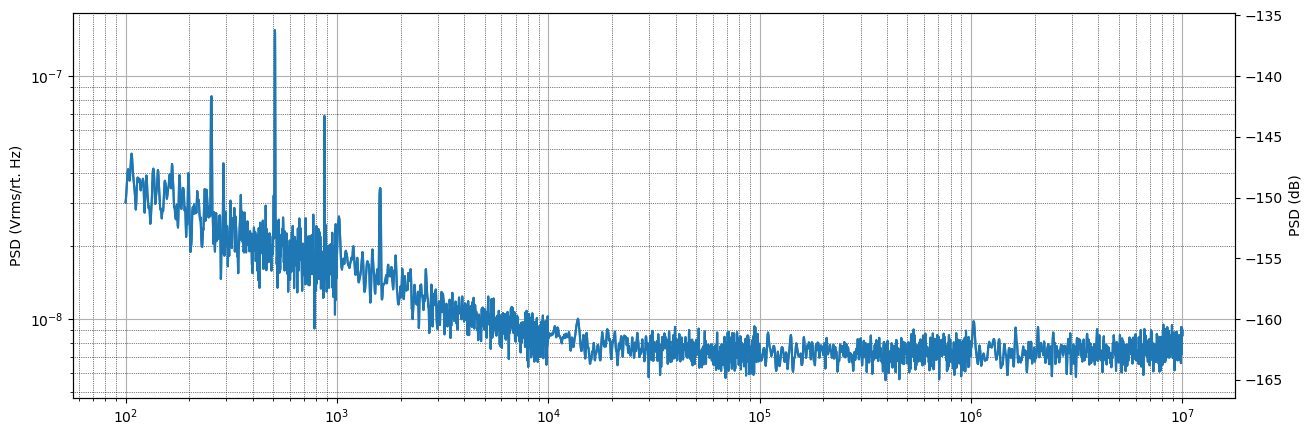

In [7]:
fig, ax = plt.subplots(figsize=[15, 5]) 
plt.loglog(output[:,0],output[:,1])
plt.grid()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.set(ylabel='PSD (Vrms/rt. Hz)')
ax2 = ax.twinx()
ax2.semilogx(output[:,0],10*np.log10(output[:,1]**2))
ax2.set(ylabel='PSD (dB)')
plt.show()

In [8]:
# all_data

In [9]:
all_data.append(dict(data=output, Vdc=2.9, signal=True, amp='SOA', curr=300, preamp=True, rsa_range=0, beam='Pump', note='100pct AOM'))
# all_data['YbAmp_0mA_0_0.020V'] = _output

In [10]:
fig, ax = plt.subplots(figsize=[13, 6])
for d in all_data[10:]:
    if not d['signal']:
        plt.loglog(d['data'][:,0], d['data'][:,1], 'k', alpha=0.5, label=f"{d['amp']} {d['curr']}mA, Power={d['Vdc']}V")
    else:
        plt.loglog(d['data'][:,0], d['data'][:,1], label=f"{d['amp']} {d['curr']}mA, Power={d['Vdc']}V ")

plt.legend()
plt.grid()
# ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.grid(which='minor', linestyle='--', alpha=0.5)
plt.xlim([1e2, 1e7])
# plt.ylim([1e-6, 1e-3])
ax.tick_params(direction='in')
ax.tick_params(which='minor', direction='in')
plt.title(f"YbAmp vs SOA")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Vrms/ rt.Hz]")
plt.tight_layout()

C:\Users\jmcdowell\AppData\Local\Temp\ipykernel_11704\1873280540.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


In [11]:
(1.117-0.778)/0.150 

2.26

In [12]:
# pickle.dump(all_data, open('YbAmp_vs_SOA.pkl', 'wb'))

In [13]:
all_data = pickle.load(open('YbAmp_vs_SOA.pkl', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'YbAmp_vs_SOA.pkl'

In [ ]:
df = pd.DataFrame(all_data)
df.loc[0:7, 'preamp'] = False
df.loc[4, 'amp'] = 'PD'
df.loc[0:7, 'rsa_range'] = -30
df.loc[0:11, 'beam'] = '1064'
df.loc[0:14, 'note'] = 'None'
df

data    Vdc  signal     amp  \
0   [[100.0, 5.887540055482532e-07], [100.5625, 6....  0.382    True      Yb   
1   [[100.0, 1.9002172848558985e-06], [100.5625, 1...  0.778    True      Yb   
2   [[100.0, 2.129086624336196e-06], [100.5625, 1....  1.117    True      Yb   
3   [[100.0, 8.871672321220103e-07], [100.5625, 9....  0.555    True      Yb   
4   [[100.0, 6.892263826330236e-08], [100.5625, 6....  0.000   False      PD   
5   [[100.0, 1.3749280469710357e-07], [100.5625, 1...  0.810    True     SOA   
6   [[100.0, 1.5059596591981972e-07], [100.5625, 1...  0.996    True     SOA   
7   [[100.0, 1.294685034736176e-07], [100.5625, 1....  0.484    True     SOA   
8   [[100.0, 1.3270498129713815e-05], [100.5625, 1...  0.765    True     SOA   
9   [[100.0, 4.712311692856019e-06], [100.5625, 4....  0.000   False      PD   
10  [[100.0, 0.00021153714624233544], [100.5625, 0...  1.011    True      Yb   
11  [[100.0, 5.42301359018893e-06], [100.5625, 5.5...  0.000   False      PD   
12  [[100.0, 0.00037080267793498933], [100.5625, 0...  0.893    True      Yb   
13  [[100.0, 4.4663743210549e-06], [100.5625, 3.95...  0.000   False  PD 532   
14  [[100.0, 0.0001415562437614426], [100.5625, 0....  0.707    True     SOA   
15  [[100.0, 0.0005779574275948107], [100.5625, 0....  0.814    True     SOA   
16  [[100.0, 0.000607578840572387], [100.5625, 0.0...  0.802    True     SOA   
17  [[100.0, 9.6754047262948e-06], [100.5625, 1.00...  0.000   False  PD 532   

   curr preamp  rsa_range   beam       note  
0   320  False      -30.0   1064       None  
1   500  False      -30.0   1064       None  
2   650  False      -30.0   1064       None  
3   400  False      -30.0   1064       None  
4     0  False      -30.0   1064       None  
5   300  False      -30.0   1064       None  
6   370  False      -30.0   1064       None  
7   200  False      -30.0   1064       None  
8   300   True        NaN   1064       None  
9     0   True        NaN   1064       None  
10  600   True        NaN   1064       None  
11    0   True      -10.0   1064       None  
12  600   True        0.0  Probe       None  
13    0   True        0.0  Probe       None  
14  300   True        0.0  Probe       None  
15  300   True        0.0   Pump  27pct AOM  
16  300   True       20.0   Pump  27pct AOM  
17    0   True       20.0   Pump  27pct AOM

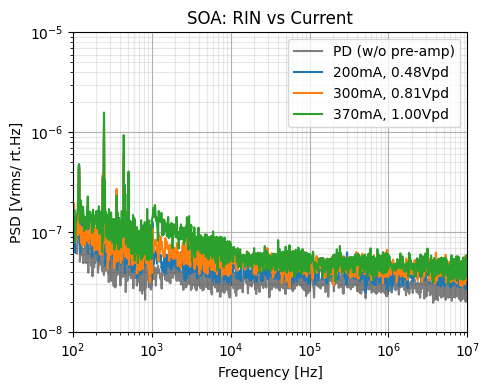

In [ ]:
# 1064 light scalings 
fig, ax = plt.subplots(figsize=[5, 4])
d = df.loc[4]
plt.loglog(d['data'][:,0], d['data'][:,1], 'k-', alpha=0.5, label=f"PD (w/o pre-amp)")
for i in [7, 5, 6]:
    d = df.loc[i]
    plt.loglog(d['data'][:,0], d['data'][:,1], label=f"{d['curr']}mA, {d['Vdc']:.2f}Vpd")
plt.legend()
plt.grid()
plt.grid(which='minor', linestyle='-', alpha=0.3)
plt.xlim([1e2, 1e7])
plt.ylim([1e-8, 1e-5])
plt.ylabel("PSD [Vrms/ rt.Hz]")
plt.xlabel("Frequency [Hz]")
plt.title(f"SOA: RIN vs Current")
plt.tight_layout()

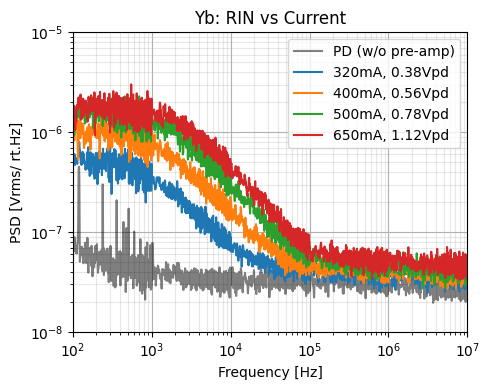

In [ ]:
# 1064 light scalings 
fig, ax = plt.subplots(figsize=[5, 4])
d = df.loc[4]
plt.loglog(d['data'][:,0], d['data'][:,1], 'k-', alpha=0.5, label=f"PD (w/o pre-amp)")
for i in [0, 3, 1, 2]:
    d = df.loc[i]
    plt.loglog(d['data'][:,0], d['data'][:,1], label=f"{d['curr']}mA, {d['Vdc']:.2f}Vpd")
plt.legend()
plt.grid()
plt.grid(which='minor', linestyle='-', alpha=0.3)
plt.xlim([1e2, 1e7])
plt.ylim([1e-8, 1e-5])
plt.ylabel("PSD [Vrms/ rt.Hz]")
plt.xlabel("Frequency [Hz]")
plt.title(f"Yb: RIN vs Current")
plt.tight_layout()

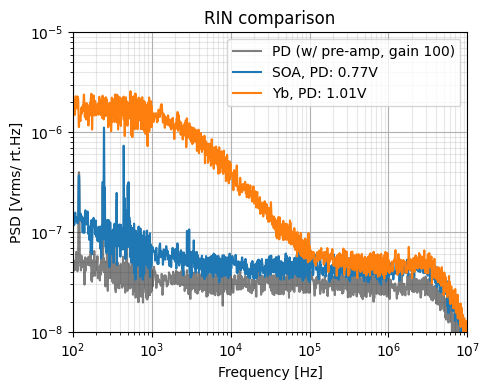

In [ ]:
# Comparison of 1064 light 
fig, ax = plt.subplots(figsize=[5, 4])
d = df.loc[11]
plt.loglog(d['data'][:,0], d['data'][:,1]/100, 'k-', alpha=0.5, label=f"PD (w/ pre-amp, gain 100)")
d = df.loc[8]
plt.loglog(d['data'][:,0], d['data'][:,1]/100, label=f"{d['amp']}, PD: {d['Vdc']:.2f}V ")
d = df.loc[10]
plt.loglog(d['data'][:,0], d['data'][:,1]/100, label=f"{d['amp']}, PD: {d['Vdc']:.2f}V")
plt.legend()
plt.grid()
plt.grid(which='minor', linestyle='-', alpha=0.3)
plt.xlim([1e2, 1e7])
plt.ylim([1e-8, 1e-5])
plt.ylabel("PSD [Vrms/ rt.Hz]")
plt.xlabel("Frequency [Hz]")
plt.title(f"RIN comparison")
plt.tight_layout()

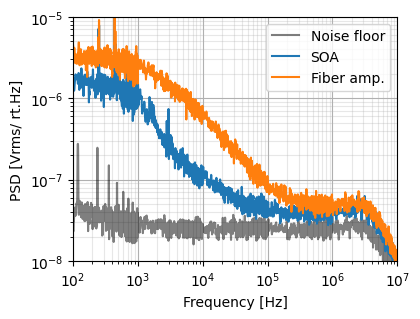

In [ ]:
# Comparison of Probe light 
fig, ax = plt.subplots(figsize=[4,3])
d = df.loc[13]
plt.loglog(d['data'][:,0], d['data'][:,1]/100, 'k-', alpha=0.5, label=f"Noise floor")
d = df.loc[14]
plt.loglog(d['data'][:,0], d['data'][:,1]/100, label=f"{d['amp']}")
d = df.loc[12]
plt.loglog(d['data'][:,0], d['data'][:,1]/100, label=f"Fiber amp.")
plt.legend()
plt.grid()
plt.grid(which='minor', linestyle='-', alpha=0.3)
plt.xlim([1e2, 1e7])
plt.ylim([1e-8, 1e-5])
plt.ylabel("PSD [Vrms/ rt.Hz]")
plt.xlabel("Frequency [Hz]")
# plt.title(f"Probe light")
plt.tight_layout(pad=0.0)

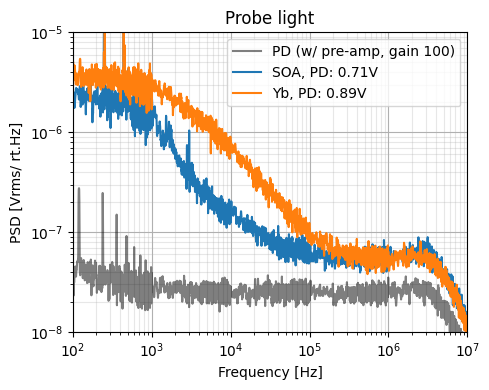

In [ ]:
# Comparison of Probe light 
fig, ax = plt.subplots(figsize=[5, 4])
d = df.loc[13]
plt.loglog(d['data'][:,0], d['data'][:,1]/100, 'k-', alpha=0.5, label=f"PD (w/ pre-amp, gain 100)")
d = df.loc[14]
plt.loglog(d['data'][:,0], d['data'][:,1]/100/d['Vdc'], label=f"{d['amp']}, PD: {d['Vdc']:.2f}V ")
d = df.loc[12]
plt.loglog(d['data'][:,0], d['data'][:,1]/100/d['Vdc'], label=f"{d['amp']}, PD: {d['Vdc']:.2f}V")
plt.legend()
plt.grid()
plt.grid(which='minor', linestyle='-', alpha=0.3)
plt.xlim([1e2, 1e7])
plt.ylim([1e-8, 1e-5])
plt.ylabel("PSD [Vrms/ rt.Hz]")
plt.xlabel("Frequency [Hz]")
plt.title(f"Probe light")
plt.tight_layout()

## Older style dict based storage

AttributeError: 'list' object has no attribute 'keys'

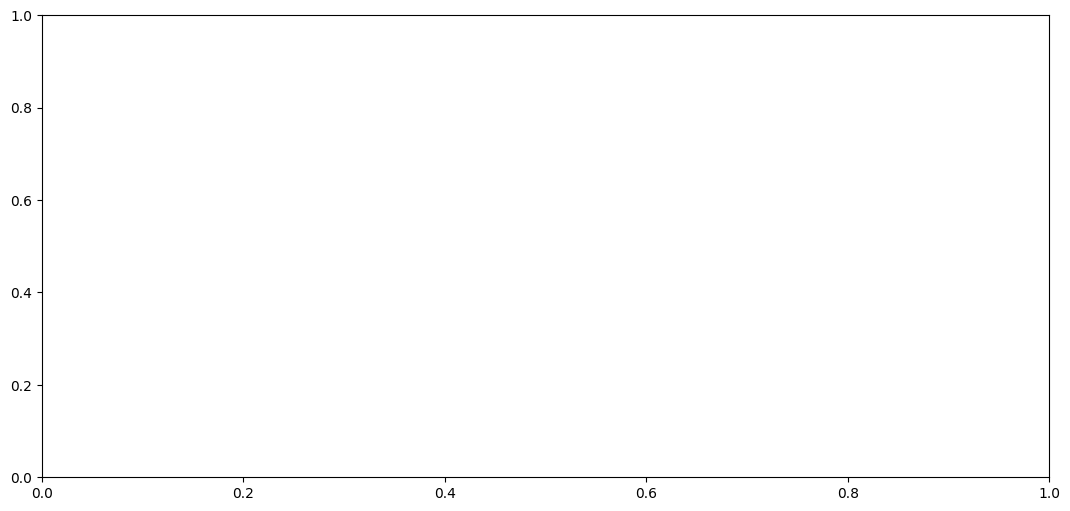

In [ ]:
fig, ax = plt.subplots(figsize=[13, 6])
for k in list(all_data.keys())[::]:
    ax.loglog(all_data[k][:,0], all_data[k][:,1], label=k)

# gamma = 0.449 
# x = np.logspace(1, 6.5, 1000) * 1e-6
# y = tp.lorentzian(x, -gamma/2, gamma, 0.145/2)
# dydx = np.abs(np.diff(y) / np.diff(x))
# # plt.plot(x, y)
# plt.plot(x[:-1]*1e6, dydx * 5e2, 'k--', linewidth=5, label='Lorentzian Derivative')

plt.legend()
plt.grid()
# ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.grid(which='minor', linestyle='--', alpha=0.5)
plt.xlim([1e1, 1e7])
# plt.ylim([1e-8, 2e-5])
ax.tick_params(direction='in')
ax.tick_params(which='minor', direction='in')
plt.title(f"Comparison between RIOs")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Vrms/ rt.Hz]")
plt.tight_layout()


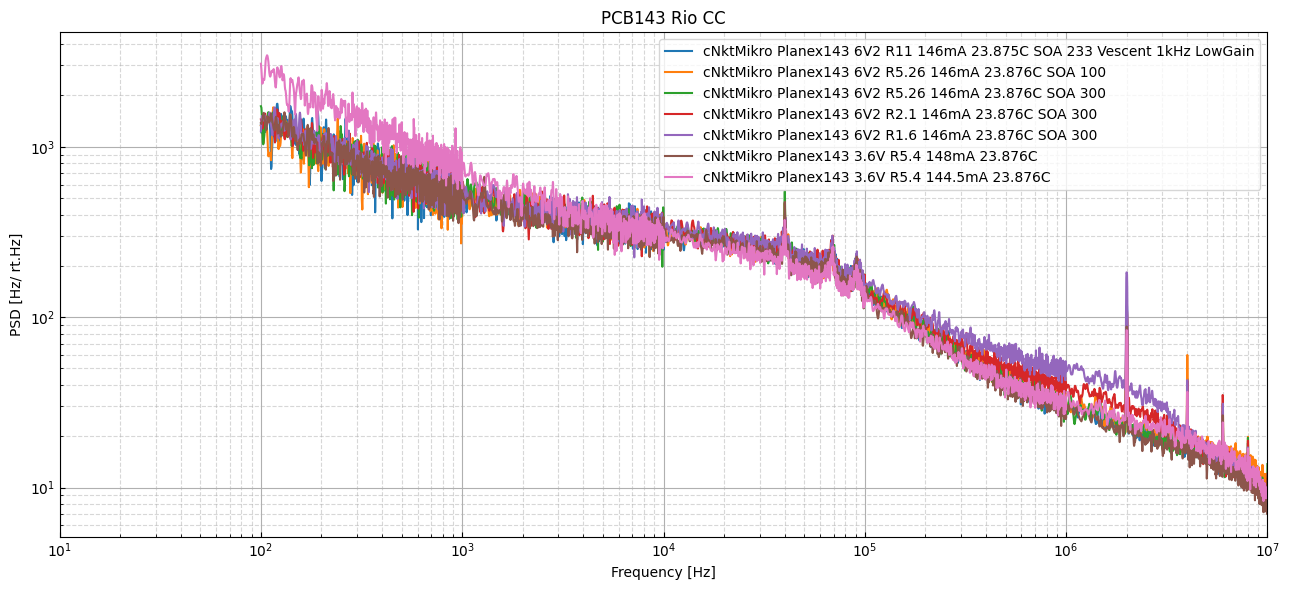

In [ ]:
fig, ax = plt.subplots(figsize=[13, 6])
for k in list(all_data.keys())[30:37]:
    ax.loglog(all_data[k][:,0], all_data[k][:,1] * y_mult, label=k)
    # xlog10 = all_data[k][:,0]
    # xb, yb = tp.binbyx(xlog10, y, step=sett['bin_step'])
    # xb = 10**xb
    # ax.loglog(xb, yb, sett['fmt'], label=sett['label'])

# plt.loglog(data_rionkt.f, data_rionkt.noise, 'k-', label='NKT-Rio')

# gamma = 0.449 
# x = np.logspace(1, 6.5, 1000) * 1e-6
# y = tp.lorentzian(x, -gamma/2, gamma, 0.145/2)
# dydx = np.abs(np.diff(y) / np.diff(x))
# # plt.plot(x, y)
# plt.plot(x[:-1]*1e6, dydx * 5e2, 'k--', linewidth=5, label='Lorentzian Derivative')

plt.legend()
plt.grid()
# ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.grid(which='minor', linestyle='--', alpha=0.5)
plt.xlim([1e1, 1e7])
# plt.ylim([1e-8, 2e-5])
ax.tick_params(direction='in')
ax.tick_params(which='minor', direction='in')
plt.title(f"PCB143 Rio CC")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Hz/ rt.Hz]")
plt.tight_layout()



AttributeError: 'list' object has no attribute 'keys'

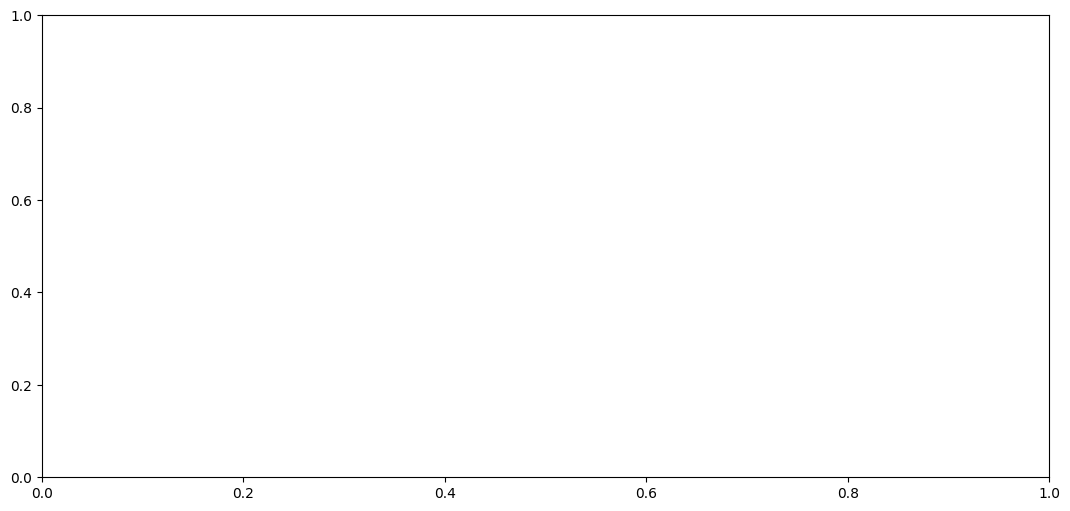

In [ ]:
fig, ax = plt.subplots(figsize=[13, 6])
for k in list(all_data.keys())[::]:
    ax.loglog(all_data[k][:,0], all_data[k][:,1], label=k)

# gamma = 0.449 
# x = np.logspace(1, 6.5, 1000) * 1e-6
# y = tp.lorentzian(x, -gamma/2, gamma, 0.145/2)
# dydx = np.abs(np.diff(y) / np.diff(x))
# # plt.plot(x, y)
# plt.plot(x[:-1]*1e6, dydx * 5e2, 'k--', linewidth=5, label='Lorentzian Derivative')

plt.legend()
plt.grid()
# ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.grid(which='minor', linestyle='--', alpha=0.5)
plt.xlim([1e1, 1e7])
# plt.ylim([1e-8, 2e-5])
ax.tick_params(direction='in')
ax.tick_params(which='minor', direction='in')
plt.title(f"Comparison between RIOs")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Vrms/ rt.Hz]")
plt.tight_layout()


In [ ]:
# fname = "20240125_phasenoise_viperorion.pkl"
# fname = "20240126_phasenoise_rio_comparisons.pkl"
# fname = "20240126_pcb143_amplitudenoise.pkl"
# fname = "20240126_pcb143_fmod_transfers.pkl" # this was bad dataset, was sending signal to seed_mod instead of SOA_mod, however it does indicate cross-talk 
# fname = "20240129_pcb143_fmod_transfers.pkl"
# fname = '20240404_143rio_tests.pkl'
# fname = '20240404_143rio_measurements.pkl'
fname = '20240405_143rio_measurements.pkl'

# with open(fname, "wb") as f:
#     pickle.dump(all_data, f)

In [ ]:
# with open("20240405_143rio_measurements.pkl", "rb") as f:
#     all_data = pickle.load(f)

# with open("20240409_RocknRio_John.pkl", "rb") as f:
#     all_data = pickle.load(f)

# Stored Data Analysis

## Jon's Rockn Noise eaters

In [ ]:
# y_mult = 64.809e6 # Hz/V 

In [ ]:
fname = "20240409_RocknRio_John.pkl"
with open(fname, 'rb') as f:
    data1 = pickle.load(f)
keys_all = list(data1.keys())
# list(keys_all)

In [ ]:
data = Munch()
data.update(data1)
# data.update(data2)
keys_all = list(data.keys())

In [ ]:
def plot_curve(ax, sett):
    k = sett['key']
    x, y = data[k][:,0], data[k][:,1] * sett['y_mult']
    if sett['bin_step'] > 0:
        xlog10 = np.log10(x) 
        xb, yb = tp.binbyx(xlog10, y, step=sett['bin_step'])
        xb = 10**xb
        ax.loglog(xb, yb, sett['fmt'], label=sett['label'])
    else:
        ax.loglog(x, y, sett['fmt'], label=sett['label'])

def setup_fig():
    fig, ax = plt.subplots(figsize=[12, 6])
    plt.grid()
    plt.grid(which='minor', linestyle='--', alpha=0.5)
    plt.xlim([1e1, 1e7])
    # plt.ylim([1e-8, 2e-5])
    ax.tick_params(direction='in')
    ax.tick_params(which='minor', direction='in')
    plt.title(f"PCB143 Frequency Noise Measurements")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("PSD [Hz/ rt.Hz]")
    return fig, ax

In [ ]:
def calc_lw(k, y_mult=y_mult, extend=False):
    x, y = data[k][:,0], data[k][:,1] * y_mult
    if extend:
        x = np.concatenate([x, data_rio143_hf.f])
        y = np.concatenate([y, data_rio143_hf.noise])
    return np.trapz(y**2, x)**0.5 / 1e3

for k in keys_all:
    print(f"{k}: {calc_lw(k):.2f} kHz")

cNktMikroLin RocknPlanex Baseline: 98.45 kHz
cNktMikroLin RocknPlanex Locked: 101.32 kHz
cNktMikroLin RocknPlanex P: 81.35 kHz
cNktMikroLin RocknPlanex P+Lag: 79.59 kHz


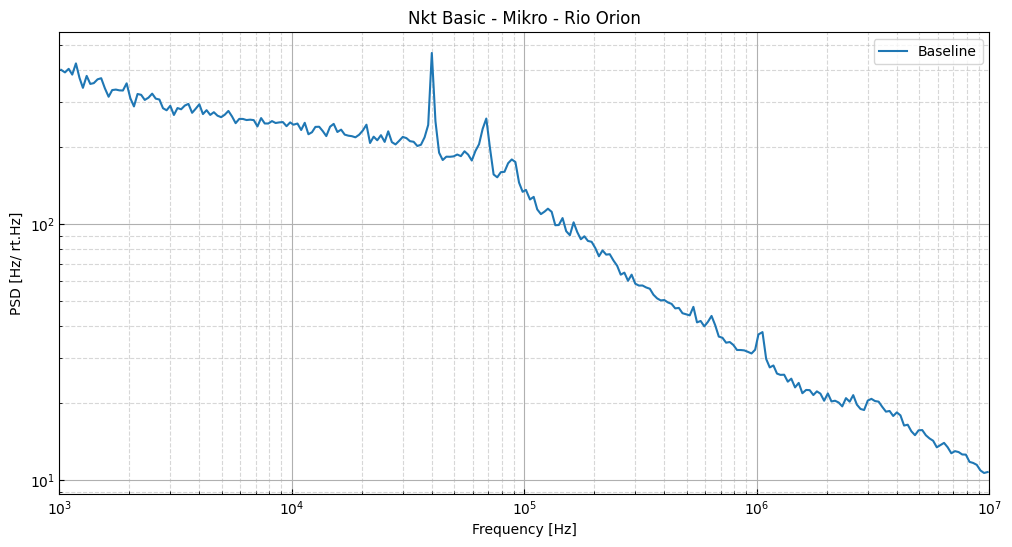

In [ ]:
# plot select keys 
base_sett = dict(
    fmt = '-', 
    bin_step = 1/64, 
    y_mult = y_mult, 
)

fig, ax = setup_fig()
plot_curve(ax, {**base_sett, **dict(key = 'cNktMikroLin RocknPlanex Baseline', label = 'Baseline')})
# plot_curve(ax, {**base_sett, **dict(key = 'cNktMikroLin RocknPlanex Locked', label = 'Locked')})
# plot_curve(ax, {**base_sett, **dict(key = 'cNktMikroLin RocknPlanex P', label = 'P gain')})
# plot_curve(ax, {**base_sett, **dict(key = 'cNktMikroLin RocknPlanex P+Lag', label = 'P + lag gain')})
# plt.loglog(data_rionkt.f, data_rionkt.noise, 'k-', label='NKT-Rio (Older data)', alpha=0.25)
# plt.loglog(data_rio143_hf.f, data_rio143_hf.noise, 'k--', label='Rio 143 (High Freq)')  
plt.xlim(1e3, 1e7)
# plt.ylim()
plt.title("Nkt Basic - Mikro - Rio Orion")
plt.legend()

## Laser phase noise FtoA

In [ ]:
# y_mult = 64.809e6 # Hz/V 

In [ ]:
fname = "20240405_143rio_measurements.pkl"
with open(fname, 'rb') as f:
    data1 = pickle.load(f)
keys_all = list(data1.keys())
# list(keys_all)

In [ ]:
data = Munch()
data.update(data1)
# data.update(data2)
keys_all = list(data.keys())
keys_all

['NktMikro cPlanex143',
 'NktMikro cOrion',
 'cOrion Planex143',
 'Orion cPlanex143',
 'equip vsa',
 'equip mitaq f2a',
 'NktBasik NktMikro PDA10A2 ManualFB',
 'NktBasik cNktMikro PDA10A2',
 'NktBasik cNktMikro PDA10A2 -30dBm Range',
 'NktBasik cRioOrion PDA10A2',
 'NktBasik cPlanex143 PDA10A2',
 'NktBasik cPlanex143 PDA10A2 wT',
 'NktBasik cPlanex143 PDA10A2 woT',
 'NktBasik cPlanex143 PDA10A2 woT UsualLowGain',
 'NktMikro cPlanex143 12V20Ohm PDA10A2',
 'NktMikro cPlanex143 12V20Ohm PDA10A2 higherGain',
 'cRioOrion Planex143 12V10Ohm PDA10A2',
 'cRioOrion Planex143 12VR20 PDA10A2',
 'cNktMikro Planex143 12VR20 PDA10A2',
 'NktMikro cPlanex143 12VR20 PDA10A2',
 'cNktMikroLin Planex143 12VR20 PDA10A2',
 'cNktMikro Planex143 6V2 R11 151mA 23.792C',
 'cNktMikro Planex143 6V2 R11 146mA 23.875C',
 'cNktMikro Planex143 6V2 R11 146mA 23.875C Scope 1MOhm -24dBm',
 'cNktMikro Planex143 6V2 R11 146mA 23.875C Scope 1MOhm -14dBm',
 'cNktMikro Planex143 6V2 R11 146mA 23.875C Scope 50Ohm -20dBm',
 'c

In [ ]:
def plot_curve(ax, sett):
    k = sett['key']
    x, y = data[k][:,0], data[k][:,1] * sett['y_mult']
    if sett['bin_step'] > 0:
        xlog10 = np.log10(x) 
        xb, yb = tp.binbyx(xlog10, y, step=sett['bin_step'])
        xb = 10**xb
        ax.loglog(xb, yb, sett['fmt'], label=sett['label'])
    else:
        ax.loglog(x, y, sett['fmt'], label=sett['label'])

def setup_fig():
    fig, ax = plt.subplots(figsize=[12, 6])
    plt.grid()
    plt.grid(which='minor', linestyle='--', alpha=0.5)
    plt.xlim([1e1, 1e7])
    # plt.ylim([1e-8, 2e-5])
    ax.tick_params(direction='in')
    ax.tick_params(which='minor', direction='in')
    plt.title(f"PCB143 Frequency Noise Measurements")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("PSD [Hz/ rt.Hz]")
    return fig, ax

In [ ]:
def calc_lw(k, y_mult=y_mult, extend=False):
    x, y = data[k][:,0], data[k][:,1] * y_mult
    if extend:
        x = np.concatenate([x, data_rio143_hf.f])
        y = np.concatenate([y, data_rio143_hf.noise])
    return np.trapz(y**2, x)**0.5 / 1e3

for k in keys_all:
    print(f"{k}: {calc_lw(k):.2f} kHz")

NktMikro cPlanex143: 265.66 kHz
NktMikro cOrion: 105.60 kHz
cOrion Planex143: 225.38 kHz
Orion cPlanex143: 244.47 kHz
equip vsa: 7.98 kHz
equip mitaq f2a: 10.64 kHz
NktBasik NktMikro PDA10A2 ManualFB: 39.09 kHz
NktBasik cNktMikro PDA10A2: 30.46 kHz
NktBasik cNktMikro PDA10A2 -30dBm Range: 28.18 kHz
NktBasik cRioOrion PDA10A2: 97.56 kHz
NktBasik cPlanex143 PDA10A2: 213.90 kHz
NktBasik cPlanex143 PDA10A2 wT: 177.19 kHz
NktBasik cPlanex143 PDA10A2 woT: 177.51 kHz
NktBasik cPlanex143 PDA10A2 woT UsualLowGain: 214.72 kHz
NktMikro cPlanex143 12V20Ohm PDA10A2: 109.26 kHz
NktMikro cPlanex143 12V20Ohm PDA10A2 higherGain: 112.02 kHz
cRioOrion Planex143 12V10Ohm PDA10A2: 152.26 kHz
cRioOrion Planex143 12VR20 PDA10A2: 139.39 kHz
cNktMikro Planex143 12VR20 PDA10A2: 118.79 kHz
NktMikro cPlanex143 12VR20 PDA10A2: 125.08 kHz
cNktMikroLin Planex143 12VR20 PDA10A2: 113.81 kHz
cNktMikro Planex143 6V2 R11 151mA 23.792C: 96.27 kHz
cNktMikro Planex143 6V2 R11 146mA 23.875C: 109.29 kHz
cNktMikro Planex143 6V

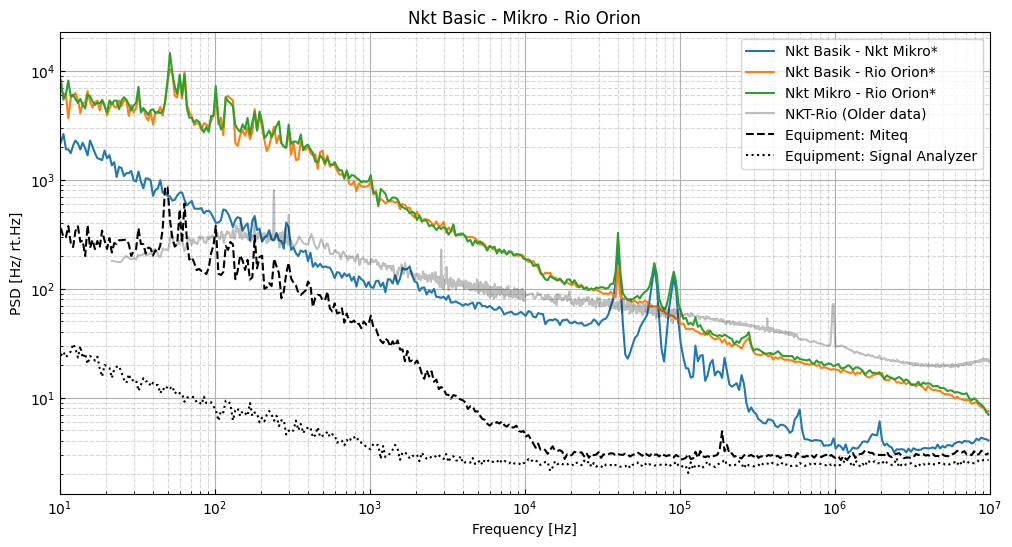

In [ ]:
# plot select keys 
base_sett = dict(
    fmt = '-', 
    bin_step = 1/64, 
    y_mult = y_mult, 
)

fig, ax = setup_fig()
plot_curve(ax, {**dict(key = 'NktBasik cNktMikro PDA10A2', label = 'Nkt Basik - Nkt Mikro*'), **base_sett})
plot_curve(ax, {**dict(key = 'NktBasik cRioOrion PDA10A2', label = 'Nkt Basik - Rio Orion*'), **base_sett})
plot_curve(ax, {**dict(key = 'NktMikro cOrion', label = 'Nkt Mikro - Rio Orion*'), **base_sett}) 
# plot_curve(ax, {**dict(key = 'Orion cPlanex143', label = 'Orion - Planex* (143 6V)'), **base_sett}) 
# plot_curve(ax, {**dict(key = 'NktMikro cPlanex143 L-60dB', label = 'Planex (143 6V)* - Nkt Mikro'), **base_sett}) 
plt.loglog(data_rionkt.f, data_rionkt.noise, 'k-', label='NKT-Rio (Older data)', alpha=0.25)
plot_curve(ax, {**base_sett, **dict(key = 'equip mitaq f2a', label = 'Equipment: Miteq', fmt='--k')}) 
plot_curve(ax, {**base_sett, **dict(key = 'equip vsa', label = 'Equipment: Signal Analyzer', fmt=':k')}) 
# plt.loglog(data_rio143_hf.f, data_rio143_hf.noise, 'k--', label='Rio 143 (High Freq)')  
# plt.xlim(1e1, 3e7)
plt.title("Nkt Basic - Mikro - Rio Orion")
plt.legend()

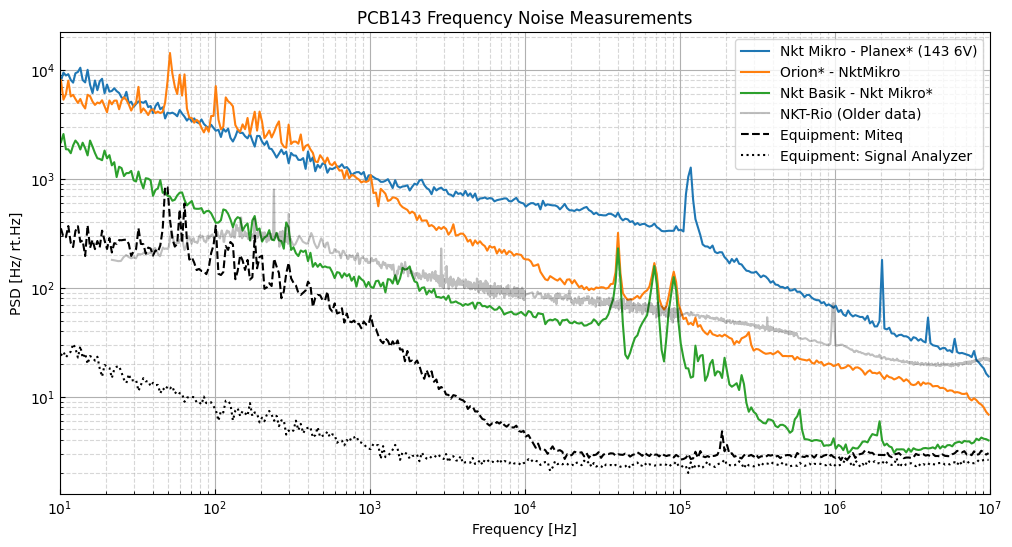

In [ ]:
# plot select keys 
base_sett = dict(
    fmt = '-', 
    bin_step = 1/64, 
    y_mult = y_mult, 
)

fig, ax = setup_fig()
plot_curve(ax, {**dict(key = 'NktMikro cPlanex143', label = 'Nkt Mikro - Planex* (143 6V)'), **base_sett})
plot_curve(ax, {**dict(key = 'NktMikro cOrion', label = 'Orion* - NktMikro'), **base_sett})
plot_curve(ax, {**dict(key = 'NktBasik cNktMikro PDA10A2', label = 'Nkt Basik - Nkt Mikro*'), **base_sett})
# plot_curve(ax, {**dict(key = 'cOrion Planex143', label = 'Orion* - Planex (143 6V)'), **base_sett}) 
# plot_curve(ax, {**dict(key = 'Orion cPlanex143', label = 'Orion - Planex* (143 6V)'), **base_sett}) 
# plot_curve(ax, {**dict(key = 'NktMikro cPlanex143 L-60dB', label = 'Planex (143 6V)* - Nkt Mikro'), **base_sett}) 
plt.loglog(data_rionkt.f, data_rionkt.noise, 'k-', label='NKT-Rio (Older data)', alpha=0.25)
plot_curve(ax, {**base_sett, **dict(key = 'equip mitaq f2a', label = 'Equipment: Miteq', fmt='--k')}) 
plot_curve(ax, {**base_sett, **dict(key = 'equip vsa', label = 'Equipment: Signal Analyzer', fmt=':k')}) 
# plt.loglog(data_rio143_hf.f, data_rio143_hf.noise, 'k--', label='Rio 143 (High Freq)')  
# plt.xlim(1e1, 3e7)
plt.legend()

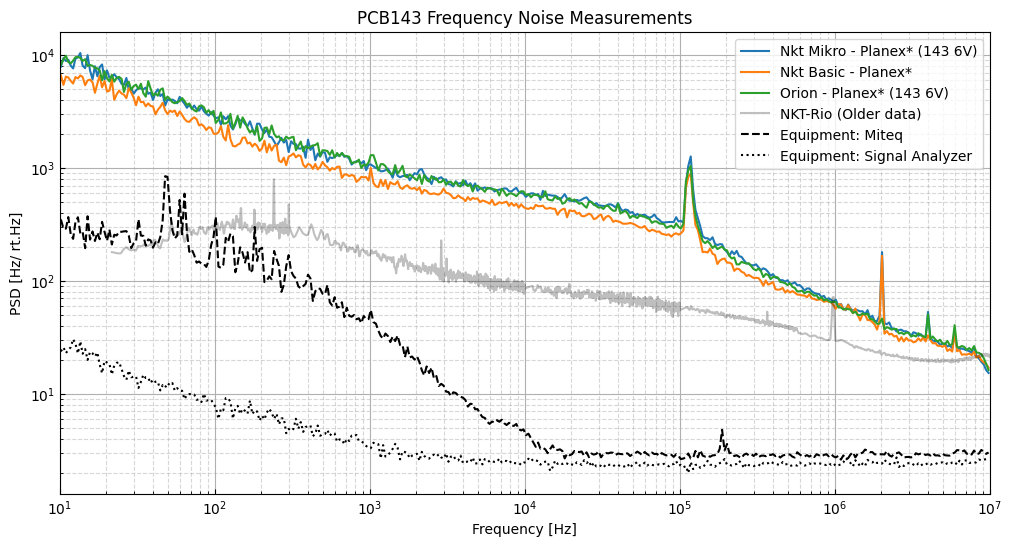

In [ ]:
# plot select keys 
base_sett = dict(
    fmt = '-', 
    bin_step = 1/64, 
    y_mult = y_mult, 
)

fig, ax = setup_fig()
plot_curve(ax, {**dict(key = 'NktMikro cPlanex143', label = 'Nkt Mikro - Planex* (143 6V)'), **base_sett})
plot_curve(ax, {**dict(key = 'NktBasik cPlanex143 PDA10A2', label = 'Nkt Basic - Planex*'), **base_sett})
# plot_curve(ax, {**dict(key = 'cOrion Planex143', label = 'Orion* - Planex (143 6V)'), **base_sett}) 
plot_curve(ax, {**dict(key = 'Orion cPlanex143', label = 'Orion - Planex* (143 6V)'), **base_sett}) 
# plot_curve(ax, {**dict(key = 'NktMikro cPlanex143 L-60dB', label = 'Planex (143 6V)* - Nkt Mikro'), **base_sett}) 
plt.loglog(data_rionkt.f, data_rionkt.noise, 'k-', label='NKT-Rio (Older data)', alpha=0.25)
plot_curve(ax, {**base_sett, **dict(key = 'equip mitaq f2a', label = 'Equipment: Miteq', fmt='--k')}) 
plot_curve(ax, {**base_sett, **dict(key = 'equip vsa', label = 'Equipment: Signal Analyzer', fmt=':k')}) 
# plt.loglog(data_rio143_hf.f, data_rio143_hf.noise, 'k--', label='Rio 143 (High Freq)')  
# plt.xlim(1e1, 3e7)
plt.legend()

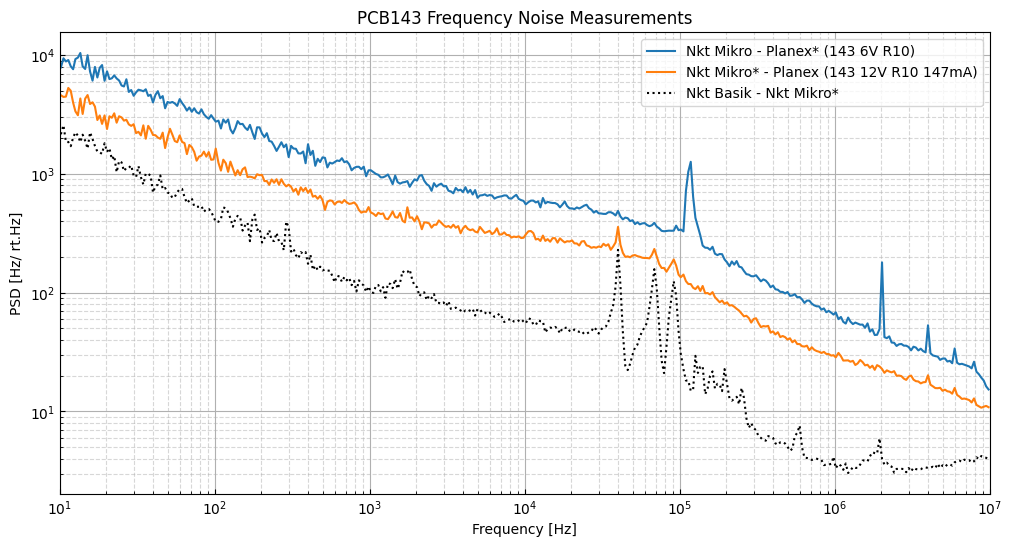

In [ ]:
# plot select keys 
base_sett = dict(
    fmt = '-', 
    bin_step = 1/64, 
    y_mult = y_mult, 
)

fig, ax = setup_fig()
plot_curve(ax, {**dict(key = 'NktMikro cPlanex143', label = r'Nkt Mikro - Planex* (143 6V R10)'), **base_sett})
plot_curve(ax, {**dict(key = 'NktMikro cPlanex143 12V20Ohm PDA10A2', label = r'Nkt Mikro* - Planex (143 12V R10 147mA)'), **base_sett}) 
# plot_curve(ax, {**dict(key = 'cRioOrion Planex143 12V10Ohm PDA10A2', label = 'Rio Orion* - Planex (143 12V 10Ohm 147mA)'), **base_sett}) 
# plot_curve(ax, {**base_sett, **dict(key = 'NktBasik cRioOrion PDA10A2', label = 'Nkt Basik - Rio Orion*', fmt=':C2')}) 
# plot_curve(ax, {**dict(key = 'cRioOrion Planex143 12VR20 PDA10A2', label = 'Rio Orion* - Planex (143 12V 20Ohm 112mA)'), **base_sett}) 
# plot_curve(ax, {**dict(key = 'cNktMikro Planex143 12VR20 PDA10A2', label = r'Nkt Mikro* - Planex (143 12V R20 145mA)'), **base_sett}) 
# plot_curve(ax, {**dict(key = 'NktMikro cPlanex143 12VR20 PDA10A2', label = r'Nkt Mikro - Planex* (143 12V R20 145mA)'), **base_sett}) 
# plot_curve(ax, {**dict(key = 'cNktMikroLin Planex143 12VR20 PDA10A2', label = r'Nkt Mikro* - Planex (143 12V R20 145mA)'), **base_sett}) 
plot_curve(ax, {**base_sett, **dict(key = 'NktBasik cNktMikro PDA10A2', label = r'Nkt Basik - Nkt Mikro*', fmt=':k')})
# plot_curve(ax, {**dict(key = 'NktBasik cPlanex143 PDA10A2', label = 'Nkt Basic - Planex*'), **base_sett})
# plot_curve(ax, {**dict(key = 'cOrion Planex143', label = 'Orion* - Planex (143 6V)'), **base_sett}) 
# plot_curve(ax, {**dict(key = 'Orion cPlanex143', label = 'Orion - Planex* (143 6V)'), **base_sett}) 
# plot_curve(ax, {**dict(key = 'NktMikro cPlanex143 L-60dB', label = 'Planex (143 6V)* - Nkt Mikro'), **base_sett}) 
# plt.loglog(data_rionkt.f, data_rionkt.noise, 'k-', label='NKT-Rio (Older data)', alpha=0.25)
# plot_curve(ax, {**base_sett, **dict(key = 'equip mitaq f2a', label = 'Equipment: Miteq', fmt='--k')}) 
# plot_curve(ax, {**base_sett, **dict(key = 'equip vsa', label = 'Equipment: Signal Analyzer', fmt=':k')}) 
# plt.loglog(data_rio143_hf.f, data_rio143_hf.noise, 'k--', label='Rio 143 (High Freq)')  
# plt.xlim(1e1, 3e7)
plt.legend()

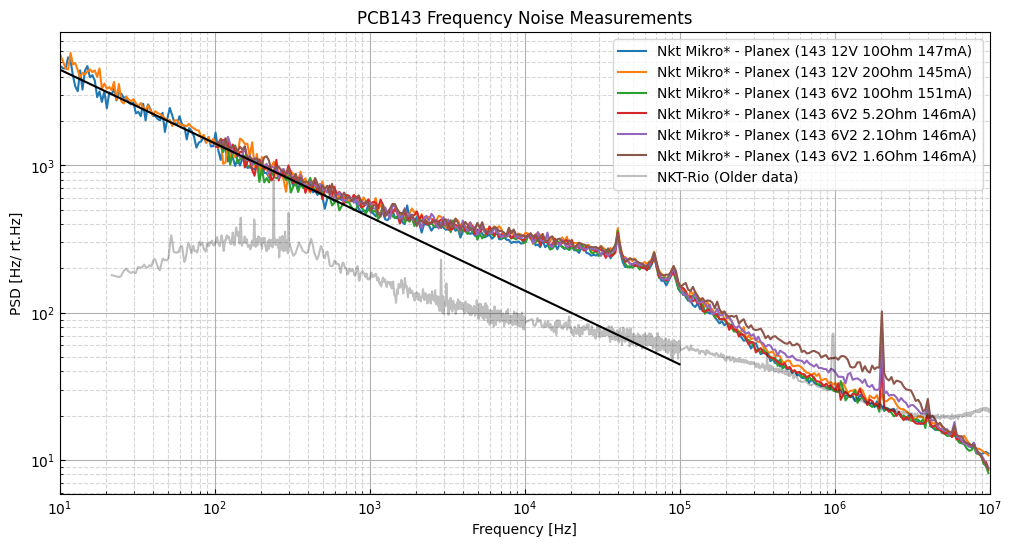

In [ ]:
# plot select keys 
base_sett = dict(
    fmt = '-', 
    bin_step = 1/64, 
    y_mult = y_mult, 
)

fig, ax = setup_fig()
# plot_curve(ax, {**dict(key = 'NktMikro cPlanex143', label = 'Nkt Mikro - Planex* (143 6V 10Ohm)'), **base_sett})
plot_curve(ax, {**dict(key = 'NktMikro cPlanex143 12V20Ohm PDA10A2', label = 'Nkt Mikro* - Planex (143 12V 10Ohm 147mA)'), **base_sett}) 
# plot_curve(ax, {**base_sett, **dict(key = 'NktBasik cNktMikro PDA10A2', label = 'Nkt Basik - Nkt Mikro*', fmt=':C1')})
# plot_curve(ax, {**dict(key = 'cRioOrion Planex143 12V10Ohm PDA10A2', label = 'Rio Orion* - Planex (143 12V 10Ohm 147mA)'), **base_sett}) 
# plot_curve(ax, {**base_sett, **dict(key = 'NktBasik cRioOrion PDA10A2', label = 'Nkt Basik - Rio Orion*', fmt=':C2')}) 
# plot_curve(ax, {**dict(key = 'cRioOrion Planex143 12VR20 PDA10A2', label = 'Rio Orion* - Planex (143 12V 20Ohm 112mA)'), **base_sett}) 
plot_curve(ax, {**dict(key = 'cNktMikro Planex143 12VR20 PDA10A2', label = 'Nkt Mikro* - Planex (143 12V 20Ohm 145mA)'), **base_sett}) 
# plot_curve(ax, {**dict(key = 'cNktMikro Planex143 6V2 R11 151mA 23.792C', label = 'Nkt Mikro* - Planex (143 6V2 10Ohm 151mA)'), **base_sett}) 
plot_curve(ax, {**dict(key = 'cNktMikro Planex143 6V2 R11 146mA 23.875C', label = 'Nkt Mikro* - Planex (143 6V2 10Ohm 151mA)'), **base_sett}) 
plot_curve(ax, {**dict(key = 'cNktMikro Planex143 6V2 R5.26 146mA 23.876C SOA 300', label = 'Nkt Mikro* - Planex (143 6V2 5.2Ohm 146mA)'), **base_sett}) 
plot_curve(ax, {**dict(key = 'cNktMikro Planex143 6V2 R2.1 146mA 23.876C SOA 300', label = 'Nkt Mikro* - Planex (143 6V2 2.1Ohm 146mA)'), **base_sett}) 
plot_curve(ax, {**dict(key = 'cNktMikro Planex143 6V2 R1.6 146mA 23.876C SOA 300', label = 'Nkt Mikro* - Planex (143 6V2 1.6Ohm 146mA)'), **base_sett}) 
# plot_curve(ax, {**dict(key = 'NktBasik cPlanex143 PDA10A2', label = 'Nkt Basic - Planex*'), **base_sett})
# plot_curve(ax, {**dict(key = 'cOrion Planex143', label = 'Orion* - Planex (143 6V)'), **base_sett}) 
# plot_curve(ax, {**dict(key = 'Orion cPlanex143', label = 'Orion - Planex* (143 6V)'), **base_sett}) 
# plot_curve(ax, {**dict(key = 'NktMikro cPlanex143 L-60dB', label = 'Planex (143 6V)* - Nkt Mikro'), **base_sett}) 
plt.loglog(data_rionkt.f, data_rionkt.noise, 'k-', label='NKT-Rio (Older data)', alpha=0.25)
# plot_curve(ax, {**base_sett, **dict(key = 'equip mitaq f2a', label = 'Equipment: Miteq', fmt='--k')}) 
# plot_curve(ax, {**base_sett, **dict(key = 'equip vsa', label = 'Equipment: Signal Analyzer', fmt=':k')}) 
# plt.loglog(data_rio143_hf.f, data_rio143_hf.noise, 'k--', label='Rio 143 (High Freq)')  
# plt.xlim(1e1, 3e7)

xp = np.logspace(1,5)
plt.plot(xp, (2e8 * 1/xp)**0.5, 'k-')
# xp = np.logspace(1,7)
# Gamma = 100e3
# plt.plot(xp, 1e5*(Gamma/(xp**2 + (Gamma/2)**2))**0.5)

# plt.axhline(100e-12 * 1.4e11, color='k', linestyle='--', label='100 pA/rtHz X 1.4E11 Hz/A')
# plt.axhline(2*100e-12 * 1.4e11, color='k', linestyle=':', label='200 pA/rtHz (expected for 5Ohm)')
# plt.axhline(5*100e-12 * 1.4e11, color='k', linestyle='-.', label='500 pA/rtHz (expected for 2Ohm)')
plt.axhline()
plt.legend()

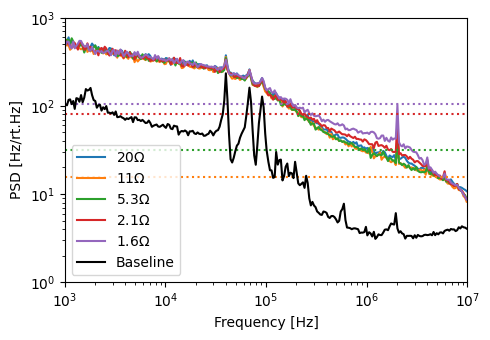

In [ ]:
# plot select keys 
base_sett = dict(
    fmt = '-', 
    bin_step = 1/64, 
    y_mult = y_mult, 
)

# fig, ax = setup_fig()
fig, ax = plt.subplots(figsize=[5, 3.5])
ax.set(xlabel='Frequency [Hz]', ylabel='PSD [Hz/rt.Hz]', xlim=[1e3, 1e7], ylim=[1e0, 1e3])
# ax.grid()

plot_curve(ax, {**dict(key = 'cNktMikro Planex143 12VR20 PDA10A2', label = r'20$\Omega$'), **base_sett}) # 9.5V
# plot_curve(ax, {**dict(key = 'NktMikro cPlanex143 12V20Ohm PDA10A2', label = '11$\Omega$, 12V'), **base_sett}) 
plot_curve(ax, {**dict(key = 'cNktMikro Planex143 6V2 R11 146mA 23.875C', label = '11$\Omega$'), **base_sett})  # 4.7V
plot_curve(ax, {**dict(key = 'cNktMikro Planex143 6V2 R5.26 146mA 23.876C SOA 300', label = '5.3$\Omega$'), **base_sett}) 
plot_curve(ax, {**dict(key = 'cNktMikro Planex143 6V2 R2.1 146mA 23.876C SOA 300', label = '2.1$\Omega$'), **base_sett}) 
plot_curve(ax, {**dict(key = 'cNktMikro Planex143 6V2 R1.6 146mA 23.876C SOA 300', label = '1.6$\Omega$'), **base_sett}) 
# plot_curve(ax, {**dict(key = 'cNktMikro Planex143 3.6V R5.4 148mA 23.876C', label = '5.4$\Omega$, 3.6V'), **base_sett})
# plt.xlim(1e1, 3e7)
plt.axhline(110e-12 * 1.4e11, color='C1', linestyle=':')#, label='11 Ohm: 110 pA/rtHz')
plt.axhline((11/5.3)*110e-12 * 1.4e11, color='C2', linestyle=':')#, label='5.3 Ohm (expected)')
plt.axhline((11/2.1)*110e-12 * 1.4e11, color='C3', linestyle=':')#, label='2.1 Ohm (expected)')
plt.axhline((11/1.6)*110e-12 * 1.4e11, color='C4', linestyle=':')#, label='1.6 Ohm (expected)')
plot_curve(ax, {**base_sett, **dict(key = 'NktBasik cNktMikro PDA10A2', label = r'Baseline', fmt='-k')})
plt.plot()
plt.axhline()
plt.legend()
plt.tight_layout()
plt.savefig("RioCC143_FNoise_Rsense.pdf")

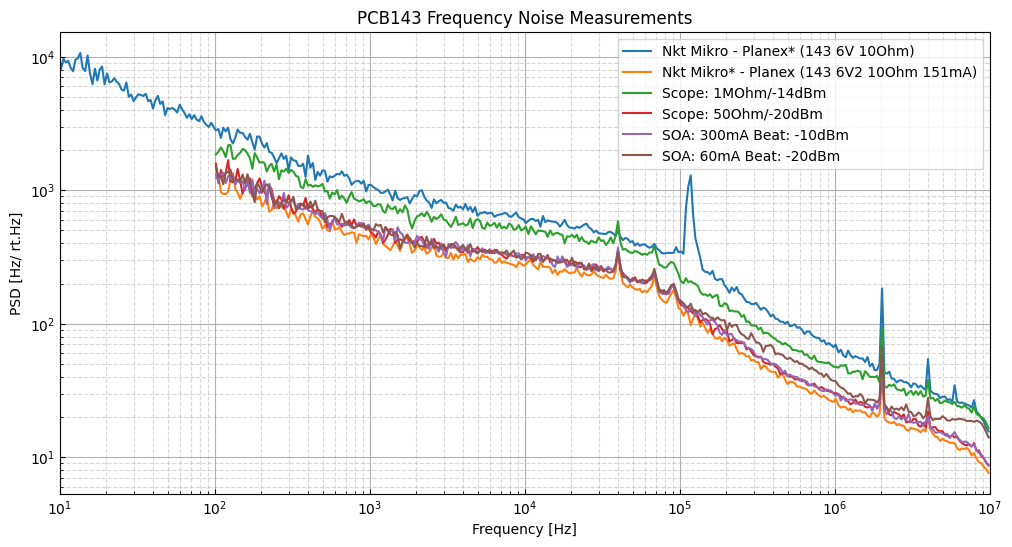

In [ ]:
# plot select keys 
base_sett = dict(
    fmt = '-', 
    bin_step = 1/64, 
    y_mult = y_mult, 
)

fig, ax = setup_fig()
plot_curve(ax, {**dict(key = 'NktMikro cPlanex143', label = 'Nkt Mikro - Planex* (143 6V 10Ohm)'), **base_sett})
# plot_curve(ax, {**dict(key = 'NktMikro cPlanex143 12V20Ohm PDA10A2', label = 'Nkt Mikro* - Planex (143 12V 10Ohm 147mA)'), **base_sett}) 
# plot_curve(ax, {**dict(key = 'cNktMikro Planex143 12VR20 PDA10A2', label = 'Nkt Mikro* - Planex (143 12V 20Ohm 145mA)'), **base_sett}) 
# plot_curve(ax, {**dict(key = 'cNktMikro Planex143 6V2 R11 151mA 23.792C', label = 'Nkt Mikro* - Planex (143 6V2 10Ohm 151mA)'), **base_sett}) 
# plot_curve(ax, {**dict(key = 'cNktMikro Planex143 6V2 R11 146mA 23.875C', label = 'Nkt Mikro* - Planex (143 6V2 10Ohm 151mA)'), **base_sett}) 
plot_curve(ax, {**dict(key = 'cNktMikro Planex143 6V2 R11 151mA 23.792C', label = 'Nkt Mikro* - Planex (143 6V2 10Ohm 151mA)'), **base_sett}) 
plot_curve(ax, {**dict(key = 'cNktMikro Planex143 6V2 R11 146mA 23.875C Scope 1MOhm -14dBm', label = 'Scope: 1MOhm/-14dBm'), **base_sett}) 
plot_curve(ax, {**dict(key = 'cNktMikro Planex143 6V2 R11 146mA 23.875C Scope 50Ohm -20dBm', label = 'Scope: 50Ohm/-20dBm'), **base_sett}) 
plot_curve(ax, {**dict(key = 'cNktMikro Planex143 6V2 R11 146mA 23.875C SOA 300 beat -10dBm', label = 'SOA: 300mA Beat: -10dBm'), **base_sett}) 
plot_curve(ax, {**dict(key = 'cNktMikro Planex143 6V2 R11 146mA 23.875C SOA 60 beat -20dBm', label = 'SOA: 60mA Beat: -20dBm'), **base_sett}) 
# plot_curve(ax, {**dict(key = 'NktBasik cPlanex143 PDA10A2', label = 'Nkt Basic - Planex*'), **base_sett})
# plt.xlim(1e1, 3e7)
plt.legend()

In [ ]:
def calc_lw(k, y_mult=y_mult, extend=False, x_min=0, x_max=1e10):
    x, y = data[k][:,0], data[k][:,1] * y_mult
    if extend:
        x = np.concatenate([x, data_rio143_hf.f])
        y = np.concatenate([y, data_rio143_hf.noise])
    mask = (x >= x_min) & (x <= x_max)
    return np.trapz(y[mask]**2, x[mask])**0.5 / 1e3

for k in keys_all:
    print(f"{k}: {calc_lw(k, x_min=1e2):.2f} kHz")

NktMikro cPlanex143: 261.54 kHz
NktMikro cOrion: 90.20 kHz
cOrion Planex143: 217.45 kHz
Orion cPlanex143: 239.81 kHz
equip vsa: 7.97 kHz
equip mitaq f2a: 10.14 kHz
NktBasik NktMikro PDA10A2 ManualFB: 28.73 kHz
NktBasik cNktMikro PDA10A2: 28.95 kHz
NktBasik cNktMikro PDA10A2 -30dBm Range: 28.18 kHz
NktBasik cRioOrion PDA10A2: 82.88 kHz
NktBasik cPlanex143 PDA10A2: 210.98 kHz
NktBasik cPlanex143 PDA10A2 wT: 175.94 kHz
NktBasik cPlanex143 PDA10A2 woT: 176.24 kHz
NktBasik cPlanex143 PDA10A2 woT UsualLowGain: 211.83 kHz
NktMikro cPlanex143 12V20Ohm PDA10A2: 106.99 kHz
NktMikro cPlanex143 12V20Ohm PDA10A2 higherGain: 110.28 kHz
cRioOrion Planex143 12V10Ohm PDA10A2: 135.48 kHz
cRioOrion Planex143 12VR20 PDA10A2: 129.61 kHz
cNktMikro Planex143 12VR20 PDA10A2: 116.40 kHz
NktMikro cPlanex143 12VR20 PDA10A2: 119.93 kHz
cNktMikroLin Planex143 12VR20 PDA10A2: 109.93 kHz
cNktMikro Planex143 6V2 R11 151mA 23.792C: 96.27 kHz
cNktMikro Planex143 6V2 R11 146mA 23.875C: 109.29 kHz
cNktMikro Planex143 6V2

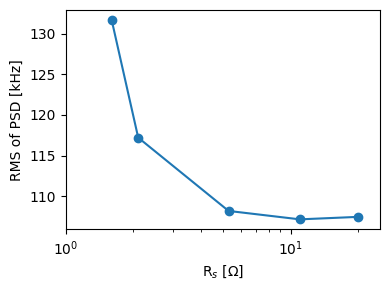

In [ ]:

plot_curve(ax, {**dict(key = 'cNktMikro Planex143 12VR20 PDA10A2', label = r'20$\Omega$'), **base_sett}) # 9.5V; 
# plot_curve(ax, {**dict(key = 'NktMikro cPlanex143 12V20Ohm PDA10A2', label = '11$\Omega$, 12V'), **base_sett}) 
plot_curve(ax, {**dict(key = 'cNktMikro Planex143 6V2 R11 146mA 23.875C', label = '11$\Omega$'), **base_sett})  # 4.7V
plot_curve(ax, {**dict(key = 'cNktMikro Planex143 6V2 R5.26 146mA 23.876C SOA 300', label = '5.3$\Omega$'), **base_sett}) 
plot_curve(ax, {**dict(key = 'cNktMikro Planex143 6V2 R2.1 146mA 23.876C SOA 300', label = '2.1$\Omega$'), **base_sett}) 
plot_curve(ax, {**dict(key = 'cNktMikro Planex143 6V2 R1.6 146mA 23.876C SOA 300', label = '1.6$\Omega$'), **base_sett}) 

keys = ['cNktMikroLin Planex143 12VR20 PDA10A2', 
        'cNktMikro Planex143 6V2 R11 146mA 23.875C', 
        'cNktMikro Planex143 6V2 R5.26 146mA 23.876C SOA 300',
        'cNktMikro Planex143 6V2 R2.1 146mA 23.876C SOA 300',
        'cNktMikro Planex143 6V2 R1.6 146mA 23.876C SOA 300']
Rsense = [20, 11, 5.3, 2.1, 1.6]
lw = []
for k in keys:
    lw.append(calc_lw(k, x_min=1e3))

fig, ax = plt.subplots(figsize=[4, 3])
plt.plot(Rsense, lw, 'o-')
plt.semilogx()
# plt.loglog()
plt.xlabel(r'R$_{s}$ [$\Omega$]')
plt.ylabel(r'RMS of PSD [kHz]')
plt.xlim(1, 25)
plt.tight_layout()

## Laser phase noise FtoA

In [ ]:
y_mult = 64.809e6 # Hz/V 

In [ ]:
fname = "20240129_pcb143_fmod_transfers.pkl"
with open(fname, 'rb') as f:
    data1 = pickle.load(f)
keys_all = list(data1.keys())
# list(keys_all)

In [ ]:
fname = "20240404_143rio_measurements.pkl"
with open(fname, 'rb') as f:
    data2 = pickle.load(f)
keys_all = list(data2.keys())
list(keys_all)

['cOrion Planex',
 'cOrion Planex BatPD',
 'test',
 'Orion cPlanex BatPD',
 'Orion cPlanex BatPD locked',
 'NktMikro cOrion',
 'NktMikro cOrion L-60dB',
 'NktMikro cPlanex143 L-60dB',
 'Instrument LightOff BatPD VsaRange0dB',
 'Instrument LightOff BatPD VsaRange0dB Highres',
 'Scope Highres',
 'Scope',
 'Miteq F2A']

In [ ]:
data = Munch()
# data.update(data1)
data.update(data2)
keys_all = list(data.keys())
keys_all

['cOrion Planex',
 'cOrion Planex BatPD',
 'test',
 'Orion cPlanex BatPD',
 'Orion cPlanex BatPD locked',
 'NktMikro cOrion',
 'NktMikro cOrion L-60dB',
 'NktMikro cPlanex143 L-60dB',
 'Instrument LightOff BatPD VsaRange0dB',
 'Instrument LightOff BatPD VsaRange0dB Highres',
 'Scope Highres',
 'Scope',
 'Miteq F2A']

In [ ]:
def plot_curve(ax, sett):
    k = sett['key']
    x, y = data[k][:,0], data[k][:,1] * sett['y_mult']
    if sett['bin_step'] > 0:
        xlog10 = np.log10(x) 
        xb, yb = tp.binbyx(xlog10, y, step=sett['bin_step'])
        xb = 10**xb
        ax.loglog(xb, yb, sett['fmt'], label=sett['label'])
    else:
        ax.loglog(x, y, sett['fmt'], label=sett['label'])

def setup_fig():
    fig, ax = plt.subplots(figsize=[12, 6])
    plt.grid()
    plt.grid(which='minor', linestyle='--', alpha=0.5)
    plt.xlim([1e1, 1e7])
    # plt.ylim([1e-8, 2e-5])
    ax.tick_params(direction='in')
    ax.tick_params(which='minor', direction='in')
    plt.title(f"PCB143 Frequency Noise Measurements")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("PSD [Hz/ rt.Hz]")
    return fig, ax

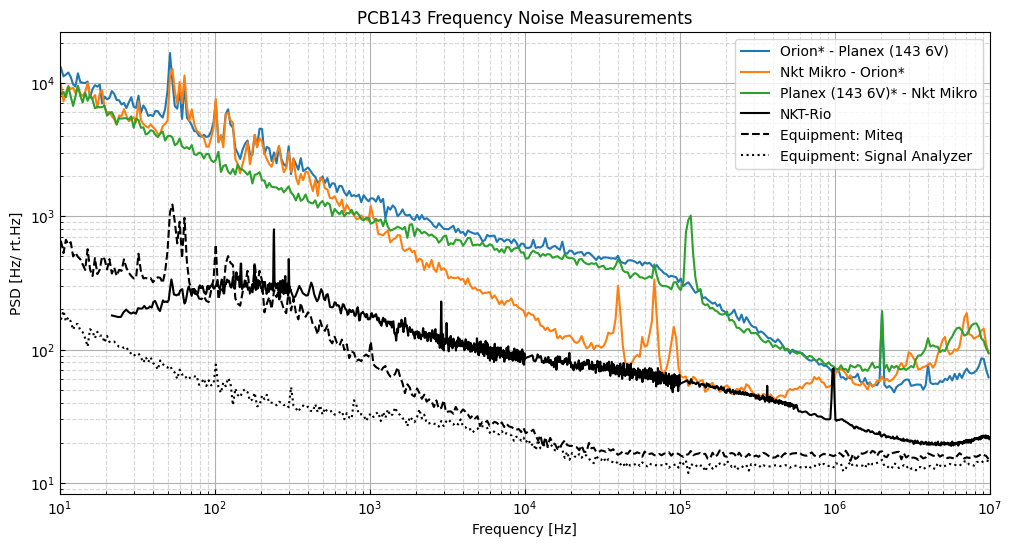

In [ ]:
# plot select keys 
base_sett = dict(
    fmt = '-', 
    bin_step = 1/64, 
    y_mult = y_mult, 
)

fig, ax = setup_fig()
plot_curve(ax, {**dict(key = 'cOrion Planex BatPD', label = 'Orion* - Planex (143 6V)'), **base_sett})
# plot_curve(ax, {**dict(key = 'Orion cPlanex BatPD', label = 'Orion - Planex* (143)'), **base_sett})
# plot_curve(ax, {**dict(key = 'NktMikro cOrion', label = 'Orion* - Nkt Mikro'), **base_sett}) 
plot_curve(ax, {**dict(key = 'NktMikro cOrion L-60dB', label = 'Nkt Mikro - Orion*'), **base_sett}) 
plot_curve(ax, {**dict(key = 'NktMikro cPlanex143 L-60dB', label = 'Planex (143 6V)* - Nkt Mikro'), **base_sett}) 
plt.loglog(data_rionkt.f, data_rionkt.noise, 'k-', label='NKT-Rio')
plot_curve(ax, {**base_sett, **dict(key = 'Miteq F2A', label = 'Equipment: Miteq', fmt='--k')}) 
plot_curve(ax, {**base_sett, **dict(key = 'Scope', label = 'Equipment: Signal Analyzer', fmt=':k')}) 
plt.legend()

In [ ]:
(700**2 * 100e3)**0.5 

221359.43621178655

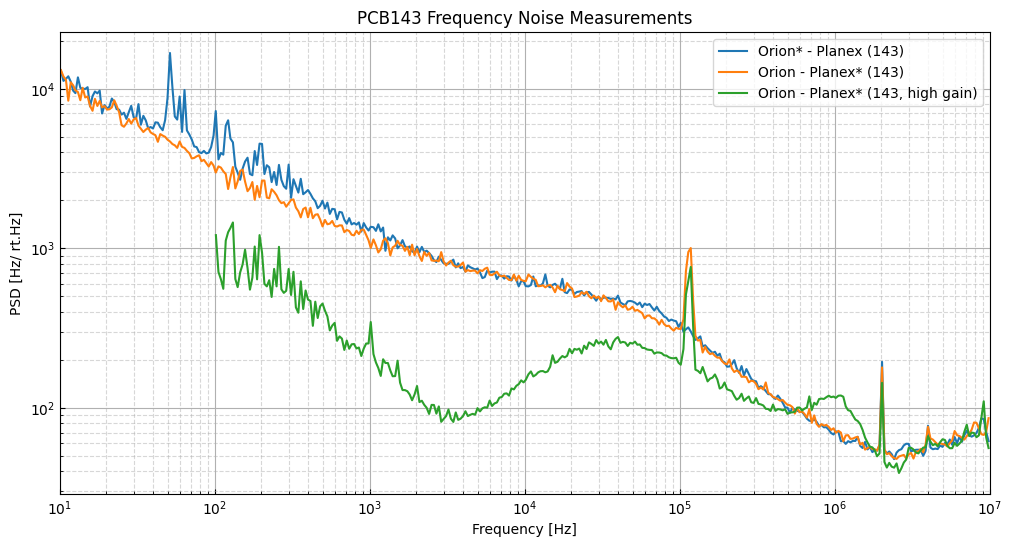

In [ ]:
# plot select keys 
base_sett = dict(
    fmt = '-', 
    bin_step = 1/64, 
    y_mult = y_mult, 
)

fig, ax = setup_fig()
plot_curve(ax, {**dict(key = 'cOrion Planex BatPD', label = 'Orion* - Planex (143)'), **base_sett})
plot_curve(ax, {**dict(key = 'Orion cPlanex BatPD', label = 'Orion - Planex* (143)'), **base_sett})
plot_curve(ax, {**dict(key = 'Orion cPlanex BatPD locked', label = 'Orion - Planex* (143, high gain)'), **base_sett})
plt.legend()

In [ ]:
fig, ax = plt.subplots(figsize=[13, 6])
for k in list(all_data.keys())[::]:
    ax.loglog(all_data[k][:,0], all_data[k][:,1] * y_mult, label=k)

plt.loglog(data_rionkt.f, data_rionkt.noise, 'k-', label='NKT-Rio')

# gamma = 0.449 
# x = np.logspace(1, 6.5, 1000) * 1e-6
# y = tp.lorentzian(x, -gamma/2, gamma, 0.145/2)
# dydx = np.abs(np.diff(y) / np.diff(x))
# # plt.plot(x, y)
# plt.plot(x[:-1]*1e6, dydx * 5e2, 'k--', linewidth=5, label='Lorentzian Derivative')

plt.legend()
plt.grid()
# ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.grid(which='minor', linestyle='--', alpha=0.5)
plt.xlim([1e1, 1e7])
# plt.ylim([1e-8, 2e-5])
ax.tick_params(direction='in')
ax.tick_params(which='minor', direction='in')
plt.title(f"PCB143 Rio CC")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Hz/ rt.Hz]")
plt.tight_layout()


## Cavity: Seed laser phase noise

In [ ]:
with open("20240125_phasenoise_viperorion.pkl", "rb") as f:
    all_data = pickle.load(f)

y_scale = 1.613e-7

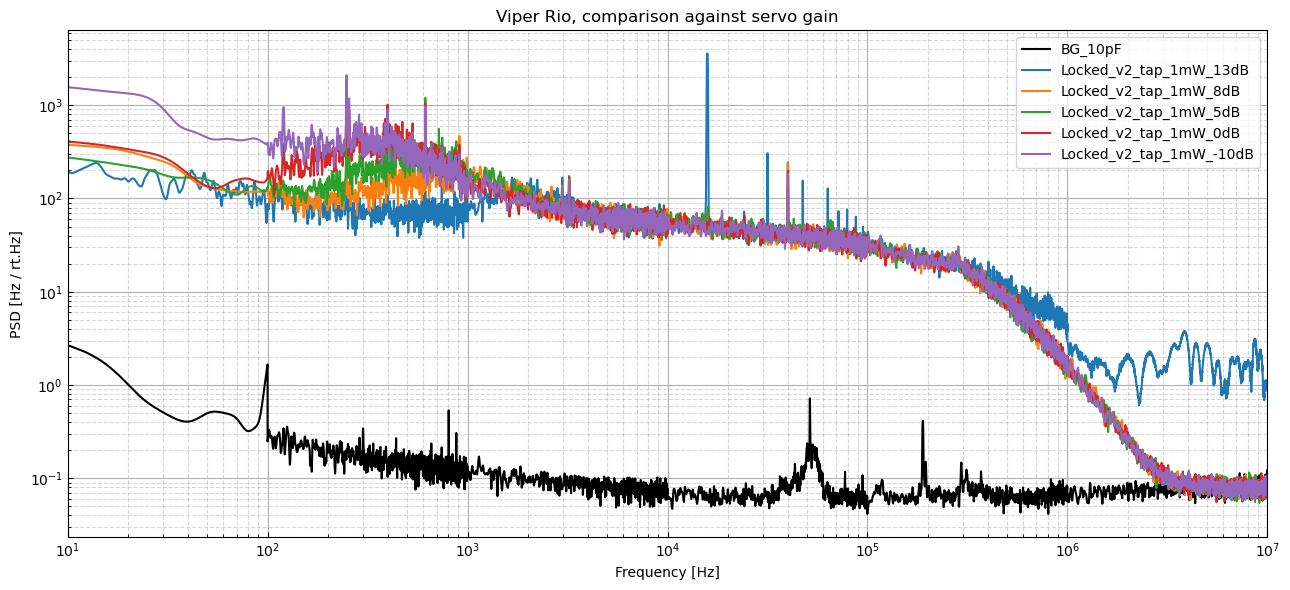

In [ ]:
fig, ax = plt.subplots(figsize=[13, 6])
k = 'BG_10pF'
ax.loglog(all_data[k][:,0], all_data[k][:,1]/y_scale, 'k-', label=k)
for k in ['Locked_v2_tap_1mW_-10dB', 'Locked_v2_tap_1mW_0dB', 'Locked_v2_tap_1mW_5dB', 'Locked_v2_tap_1mW_8dB', 'Locked_v2_tap_1mW_13dB'][::-1]:
    ax.loglog(all_data[k][:,0], all_data[k][:,1]/y_scale, label=k)

plt.legend()
plt.grid()
# ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.grid(which='minor', linestyle='--', alpha=0.5)
plt.xlim([1e1, 1e7])
# plt.ylim([1e-8, 2e-5])
ax.tick_params(direction='in')
ax.tick_params(which='minor', direction='in')
plt.title(f"Viper Rio, comparison against servo gain")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Hz / rt.Hz]")
plt.tight_layout()

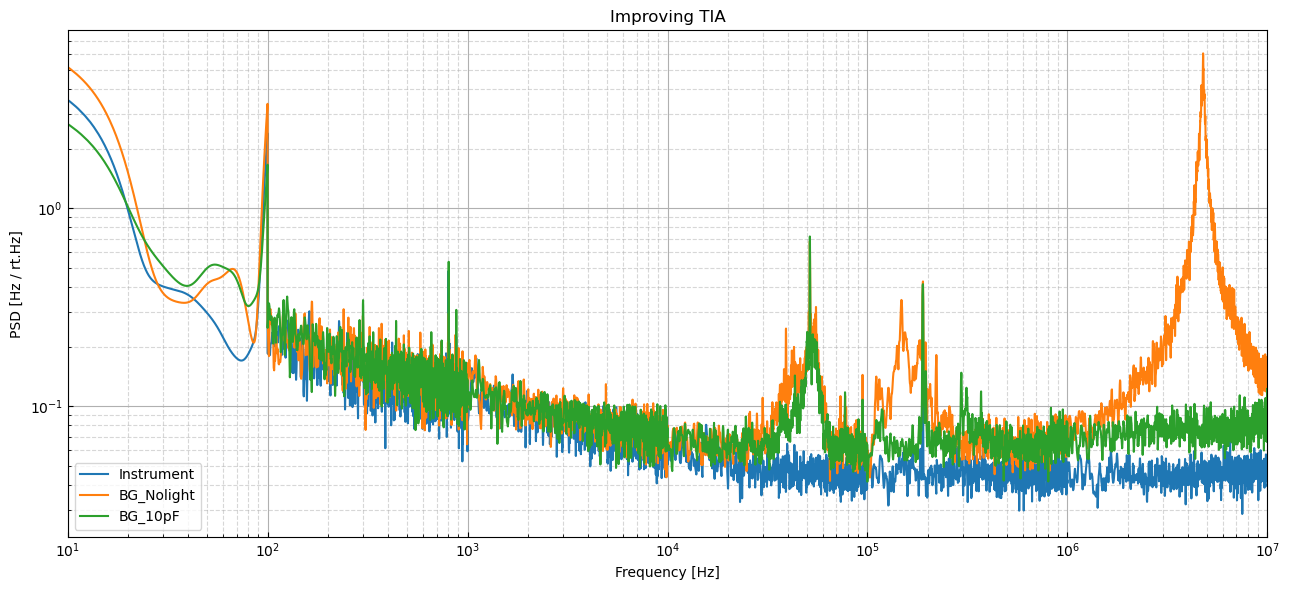

In [ ]:
fig, ax = plt.subplots(figsize=[13, 6])
for k in ['Instrument', 'BG_Nolight', 'BG_10pF', ]:
    ax.loglog(all_data[k][:,0], all_data[k][:,1]/y_scale, label=k)

plt.legend()
plt.grid()
# ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.grid(which='minor', linestyle='--', alpha=0.5)
plt.xlim([1e1, 1e7])
# plt.ylim([1e-8, 2e-5])
ax.tick_params(direction='in')
ax.tick_params(which='minor', direction='in')
plt.title(f"Improving TIA")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Hz / rt.Hz]")
plt.tight_layout()

## Rio comparisons

In [ ]:
with open("20240126_phasenoise_rio_comparisons.pkl", "rb") as f:
    all_data = pickle.load(f)

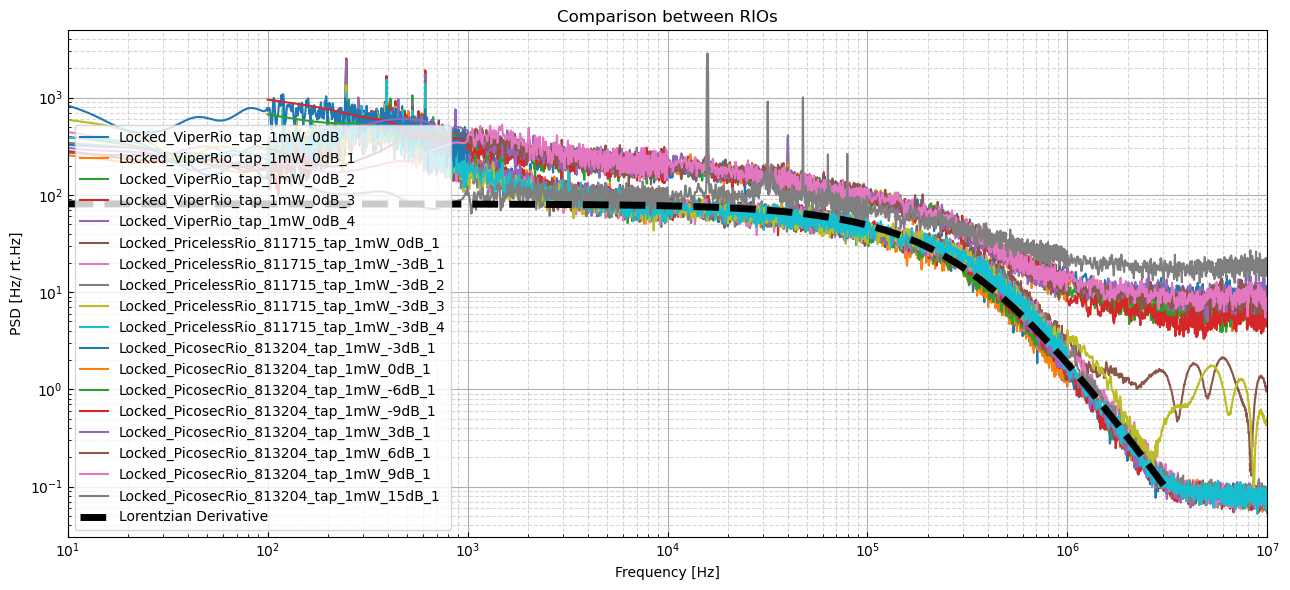

In [ ]:
fig, ax = plt.subplots(figsize=[13, 6])
for k in list(all_data.keys()):
    ax.loglog(all_data[k][:,0], all_data[k][:,1]/y_scale, label=k)

gamma = 0.449 
x = np.logspace(1, 6.5, 1000) * 1e-6
y = tp.lorentzian(x, -gamma/2, gamma, 0.145/2)
dydx = np.abs(np.diff(y) / np.diff(x))
# plt.plot(x, y)
plt.plot(x[:-1]*1e6, dydx * 5e2, 'k--', linewidth=5, label='Lorentzian Derivative')

plt.legend()
plt.grid()
# ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.grid(which='minor', linestyle='--', alpha=0.5)
plt.xlim([1e1, 1e7])
# plt.ylim([1e-8, 2e-5])
ax.tick_params(direction='in')
ax.tick_params(which='minor', direction='in')
plt.title(f"Comparison between RIOs")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Hz/ rt.Hz]")
plt.tight_layout()


## PCB 143

In [ ]:
fig, ax = plt.subplots(figsize=[13, 6])
for k in list(all_data.keys())[::]:
    ax.loglog(all_data[k][:,0], all_data[k][:,1], label=k)

# gamma = 0.449 
# x = np.logspace(1, 6.5, 1000) * 1e-6
# y = tp.lorentzian(x, -gamma/2, gamma, 0.145/2)
# dydx = np.abs(np.diff(y) / np.diff(x))
# # plt.plot(x, y)
# plt.plot(x[:-1]*1e6, dydx * 5e2, 'k--', linewidth=5, label='Lorentzian Derivative')

plt.legend()
plt.grid()
# ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.grid(which='minor', linestyle='--', alpha=0.5)
plt.xlim([1e1, 1e7])
# plt.ylim([1e-8, 2e-5])
ax.tick_params(direction='in')
ax.tick_params(which='minor', direction='in')
plt.title(f"Comparison between RIOs")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Hz/ rt.Hz]")
plt.tight_layout()


# Liquid Lens

## Optotune 

Notes:
- Direct, 20dB, about 1V
- Through optotune, 20dB, 0mA: 0.94V 
- 2mA: 0.6V
- 4mA: 0.3V 
- 6mA: 0.1V

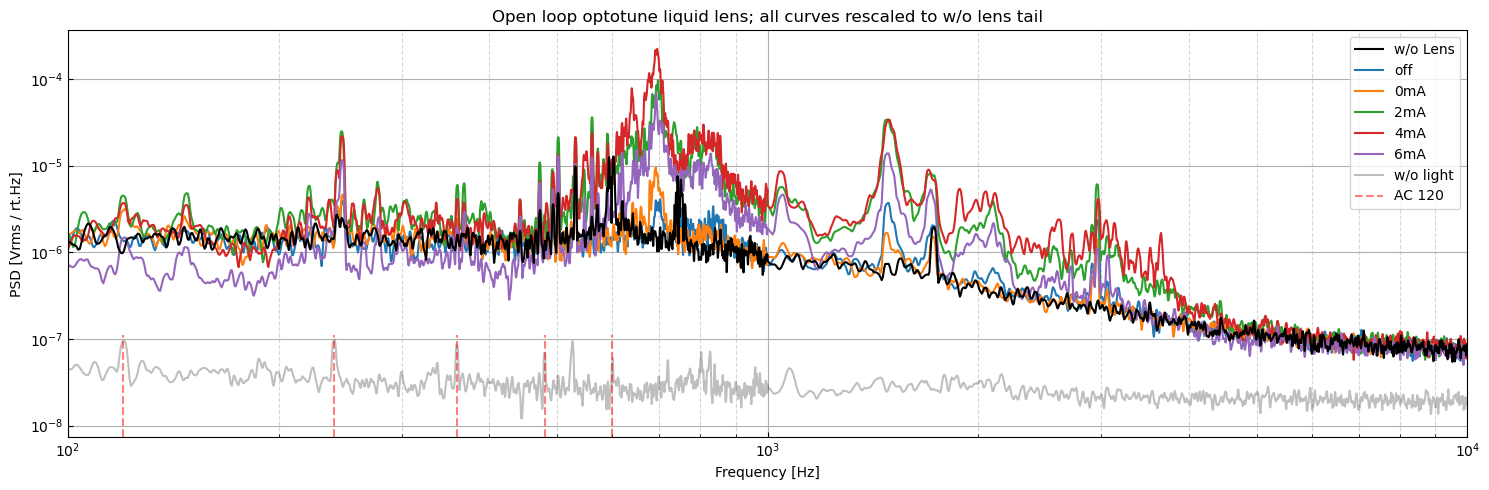

In [ ]:
fig, ax = plt.subplots(figsize=[15, 5])

k = 'direct_fiber_20dB'
ax.loglog(all_data[k][:,0], all_data[k][:,1], 'k-', label='w/o Lens', alpha=1, zorder=10)

tail_value = all_data[k][-1000:,1].mean()
labels = ['off', '0mA', '2mA', '4mA', '6mA']
multiplier = [1/0.94, 1/0.94, 1/0.6, 1/0.3, 1/0.1]
for i, k in enumerate(['optotune_off_fiber_20dB', 'optotune_0mA_fiber_20dB', 'optotune_2mA_fiber_20dB', 'optotune_4mA_fiber_20dB', 'optotune_6mA_fiber_20dB']):
    # ax.semilogx(all_data[k][:,0], 10*np.log10((all_data[k][:,1])**2), label=labels[i], zorder=2)
    # ax.semilogx(all_data[k][:,0], 10*np.log10((all_data[k][:,1] * multiplier[i])**2), label=labels[i], zorder=2)
    mult = tail_value / all_data[k][-1000:,1].mean()
    ax.loglog(all_data[k][:,0], all_data[k][:,1] * mult, label=labels[i], zorder=2)

k = 'pd_20dB'
ax.loglog(all_data[k][:,0], all_data[k][:,1], 'k-', label='w/o light', alpha=0.25)

for i, v in enumerate([120, 240, 360, 480, 600]):
    ax.axvline(v, color='r', linestyle='--', alpha=0.5, ymax=0.25, label="AC 120" if i==0 else "")

plt.legend()
plt.grid()
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
# ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
plt.grid(which='minor', linestyle='--', alpha=0.5)
plt.xlim([1e2, 1e4])
ax.tick_params(direction='in')
ax.tick_params(which='minor', direction='in')
plt.title(f"Open loop optotune liquid lens; all curves rescaled to w/o lens tail")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Vrms / rt.Hz]")
plt.tight_layout()

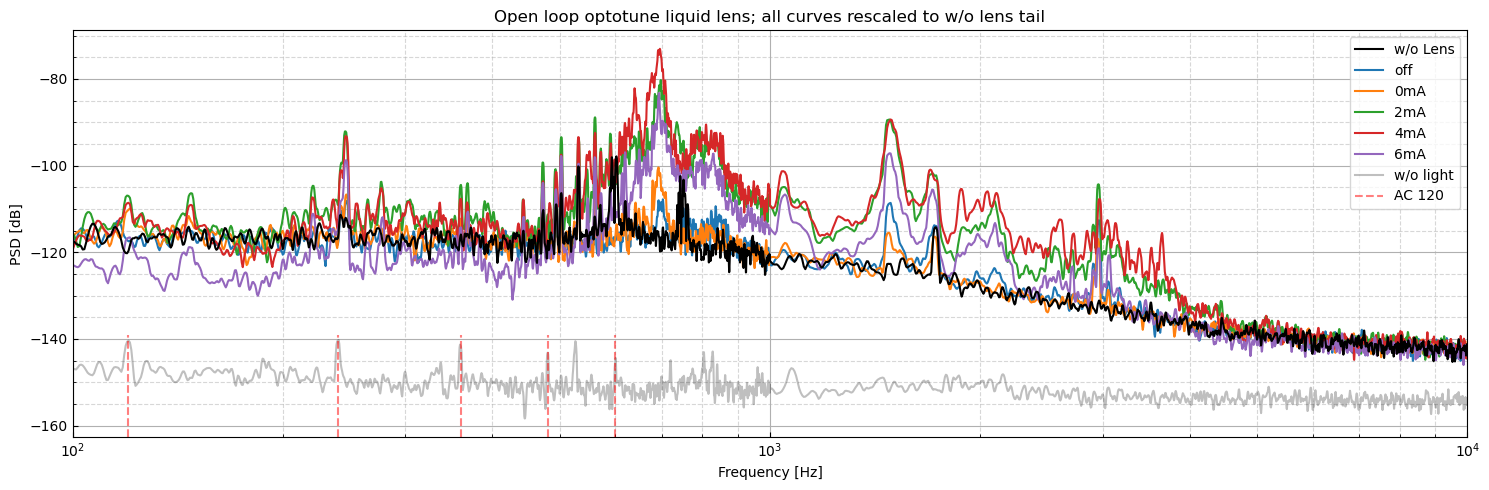

In [ ]:
fig, ax = plt.subplots(figsize=[15, 5])

k = 'direct_fiber_20dB'
ax.semilogx(all_data[k][:,0], 10*np.log10(all_data[k][:,1]**2), 'k-', label='w/o Lens', alpha=1, zorder=10)

tail_value = all_data[k][-1000:,1].mean()
labels = ['off', '0mA', '2mA', '4mA', '6mA']
multiplier = [1/0.94, 1/0.94, 1/0.6, 1/0.3, 1/0.1]
for i, k in enumerate(['optotune_off_fiber_20dB', 'optotune_0mA_fiber_20dB', 'optotune_2mA_fiber_20dB', 'optotune_4mA_fiber_20dB', 'optotune_6mA_fiber_20dB']):
    # ax.semilogx(all_data[k][:,0], 10*np.log10((all_data[k][:,1])**2), label=labels[i], zorder=2)
    # ax.semilogx(all_data[k][:,0], 10*np.log10((all_data[k][:,1] * multiplier[i])**2), label=labels[i], zorder=2)
    mult = tail_value / all_data[k][-1000:,1].mean()
    ax.semilogx(all_data[k][:,0], 10*np.log10((all_data[k][:,1] * mult)**2), label=labels[i], zorder=2)

k = 'pd_20dB'
ax.semilogx(all_data[k][:,0], 10*np.log10(all_data[k][:,1]**2), 'k-', label='w/o light', alpha=0.25)

for i, v in enumerate([120, 240, 360, 480, 600]):
    ax.axvline(v, color='r', linestyle='--', alpha=0.5, ymax=0.25, label="AC 120" if i==0 else "")

plt.legend()
plt.grid()
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.grid(which='minor', linestyle='--', alpha=0.5)
plt.xlim([1e2, 1e4])
ax.tick_params(direction='in')
ax.tick_params(which='minor', direction='in')
plt.title(f"Open loop optotune liquid lens; all curves rescaled to w/o lens tail")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [dB]")
plt.tight_layout()

In [ ]:
with open("open_loop_optotune_liquid_lens.pkl", "wb") as f:
    pickle.dump(all_data, f)

In [ ]:
with open("open_loop_optotune_liquid_lens.pkl", "rb") as f:
    all_data_2 = pickle.load(f)

# Plots

## Open Loop Optotune

In [ ]:
with open("open_loop_optotune_liquid_lens.pkl", "rb") as f:
    all_data = pickle.load(f)
print(all_data.keys())

dict_keys(['pd_0dB', 'pd_0dB_2', 'pd_10dB', 'pd_20dB', 'pd_30dB', 'pd_40dB', 'direct_fiber_20dB', 'optotune_0mA_fiber_20dB', 'optotune_2mA_fiber_20dB', 'optotune_4mA_fiber_20dB', 'optotune_6mA_fiber_20dB', 'optotune_off_fiber_20dB'])


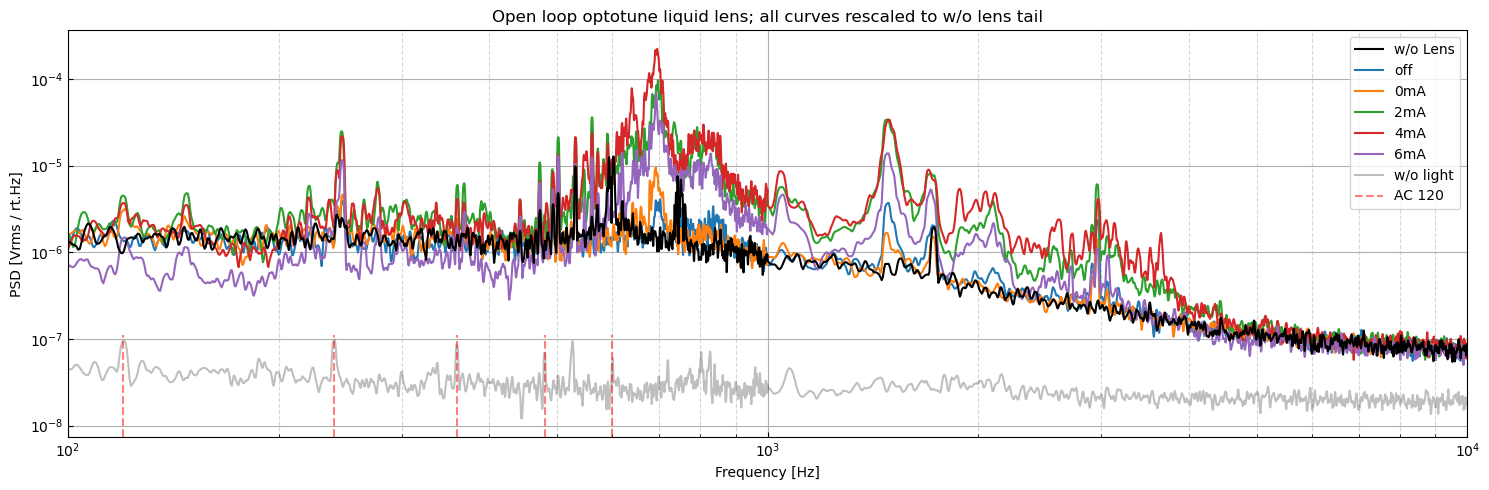

In [ ]:
fig, ax = plt.subplots(figsize=[15, 5])

k = 'direct_fiber_20dB'
ax.loglog(all_data[k][:,0], all_data[k][:,1], 'k-', label='w/o Lens', alpha=1, zorder=10)

tail_value = all_data[k][-1000:,1].mean()
labels = ['off', '0mA', '2mA', '4mA', '6mA']
multiplier = [1/0.94, 1/0.94, 1/0.6, 1/0.3, 1/0.1]
for i, k in enumerate(['optotune_off_fiber_20dB', 'optotune_0mA_fiber_20dB', 'optotune_2mA_fiber_20dB', 'optotune_4mA_fiber_20dB', 'optotune_6mA_fiber_20dB']):
    # ax.semilogx(all_data[k][:,0], 10*np.log10((all_data[k][:,1])**2), label=labels[i], zorder=2)
    # ax.semilogx(all_data[k][:,0], 10*np.log10((all_data[k][:,1] * multiplier[i])**2), label=labels[i], zorder=2)
    mult = tail_value / all_data[k][-1000:,1].mean()
    ax.loglog(all_data[k][:,0], all_data[k][:,1] * mult, label=labels[i], zorder=2)

k = 'pd_20dB'
ax.loglog(all_data[k][:,0], all_data[k][:,1], 'k-', label='w/o light', alpha=0.25)

for i, v in enumerate([120, 240, 360, 480, 600]):
    ax.axvline(v, color='r', linestyle='--', alpha=0.5, ymax=0.25, label="AC 120" if i==0 else "")

plt.legend()
plt.grid()
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
# ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
plt.grid(which='minor', linestyle='--', alpha=0.5)
plt.xlim([1e2, 1e4])
ax.tick_params(direction='in')
ax.tick_params(which='minor', direction='in')
plt.title(f"Open loop optotune liquid lens; all curves rescaled to w/o lens tail")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Vrms / rt.Hz]")
plt.tight_layout()

## Closed loop optotune

dict_keys(['pd_20dB', 'optotune_0mA_20dB', 'optotune_2mA_20dB', 'closed_m9dB_400Hz_2mA_20dB', 'closed_m11dB_900Hz_2mA_20dB', 'closed_m7dB_100Hz_2mA_20dB', 'direct_fiber_20dB'])


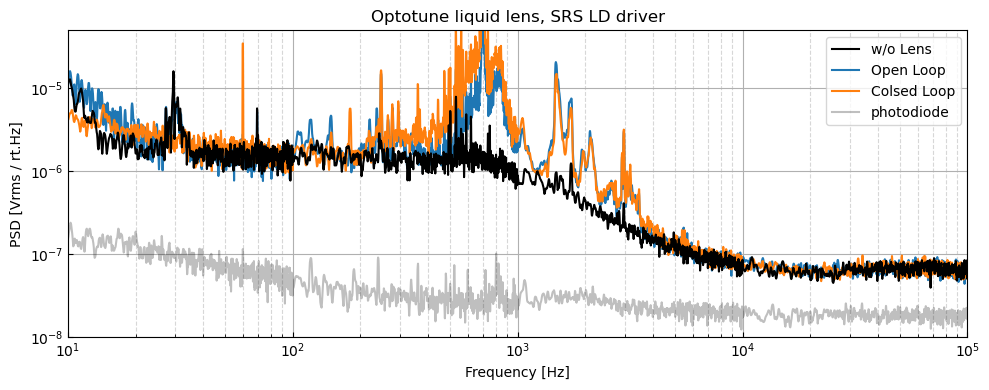

In [ ]:
with open("closed_loop_optotune_liquid_lens.pkl", "rb") as f:
    all_data = pickle.load(f)
print(all_data.keys())

fig, ax = plt.subplots(figsize=[10, 4])

k = 'direct_fiber_20dB'
ax.loglog(all_data[k][:,0], all_data[k][:,1], 'k-', label='w/o Lens', alpha=1, zorder=10)

tail_value = all_data[k][-1000:,1].mean()
labels = ['Open Loop', 'Colsed Loop']
for i, k in enumerate(['optotune_2mA_20dB', 'closed_m9dB_400Hz_2mA_20dB']):
    mult = tail_value / all_data[k][-1000:,1].mean()
    # mult = 1
    ax.loglog(all_data[k][:,0], all_data[k][:,1] * mult, label=labels[i], zorder=2)

k = 'pd_20dB'
ax.loglog(all_data[k][:,0], all_data[k][:,1], 'k-', label='photodiode', alpha=0.25)

# for i, v in enumerate([60, 120, 240, 360, 480, 600]):
#     ax.axvline(v, color='r', linestyle='--', alpha=0.5, ymax=0.25, label="AC" if i==0 else "")

plt.legend()
plt.grid()
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.grid(which='minor', linestyle='--', alpha=0.5)
plt.xlim([1e1, 1e5])
plt.ylim([1e-8, 5e-5])
ax.tick_params(direction='in')
ax.tick_params(which='minor', direction='in')
plt.title(f"Optotune liquid lens, SRS LD driver")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Vrms / rt.Hz]")
plt.tight_layout()

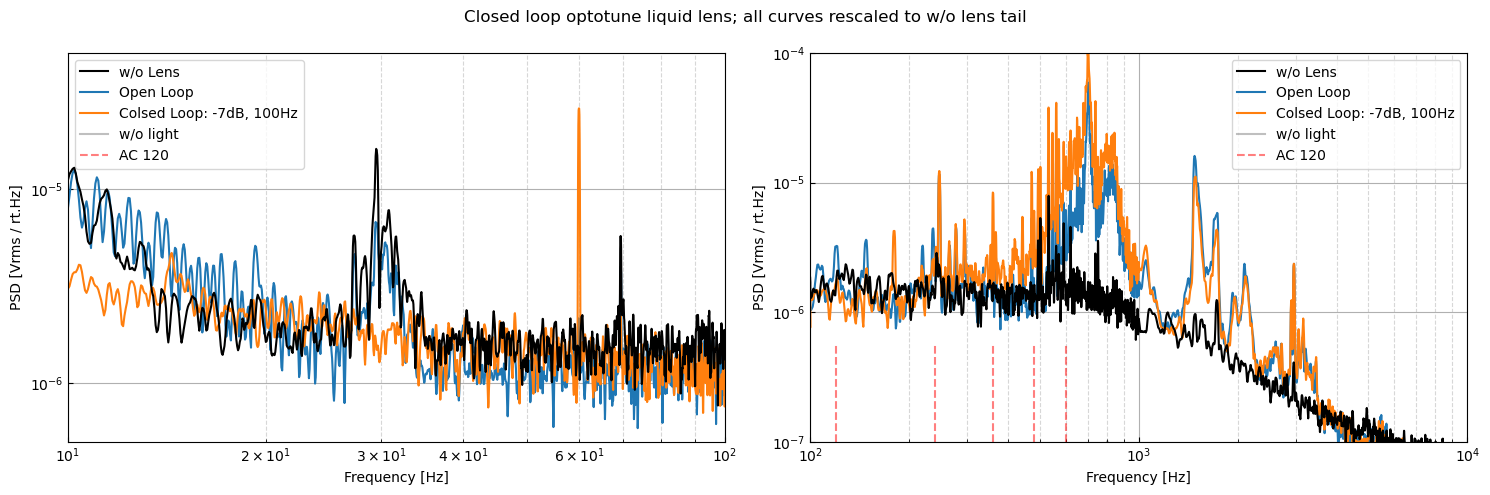

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=[15, 5])

for ax in axs:
    plt.sca(ax)
    k = 'direct_fiber_20dB'
    ax.loglog(all_data[k][:,0], all_data[k][:,1], 'k-', label='w/o Lens', alpha=1, zorder=10)

    tail_value = all_data[k][-1000:,1].mean()
    labels = ['Open Loop', 'Colsed Loop: -7dB, 100Hz', '2mA', '4mA', '6mA']
    for i, k in enumerate(['optotune_2mA_20dB', 'closed_m9dB_400Hz_2mA_20dB']):
        mult = tail_value / all_data[k][-1000:,1].mean()
        mult = 1
        ax.loglog(all_data[k][:,0], all_data[k][:,1] * mult, label=labels[i], zorder=2)

    k = 'pd_20dB'
    ax.loglog(all_data[k][:,0], all_data[k][:,1], 'k-', label='w/o light', alpha=0.25)

    for i, v in enumerate([120, 240, 360, 480, 600]):
        ax.axvline(v, color='r', linestyle='--', alpha=0.5, ymax=0.25, label="AC 120" if i==0 else "")

    plt.legend()
    plt.grid()
    ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
    plt.grid(which='minor', linestyle='--', alpha=0.5)
    ax.tick_params(direction='in')
    ax.tick_params(which='minor', direction='in')
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("PSD [Vrms / rt.Hz]")

plt.suptitle(f"Closed loop optotune liquid lens; all curves rescaled to w/o lens tail")
axs[0].set(xlim=[1e1, 1e2], ylim=[5e-7, 5e-5])
axs[1].set(xlim=[1e2, 1e4], ylim=[1e-7, 1e-4])
plt.tight_layout()

## Varioptic Open loop

In [ ]:
with open("open_loop_varioptic_liquid_lens.pkl", "rb") as f:
    all_data = pickle.load(f)
print(all_data.keys())

dict_keys(['pd_20dB', 'direct_20dB', 'varioptic_42.21V_20dB', 'varioptic_42.61V_20dB', 'varioptic_41.96V_20dB', 'varioptic_42.08V_20dB', 'varioptic_42.15V_20dB', 'varioptic_42.30V_20dB', 'varioptic_42.25V_20dB'])


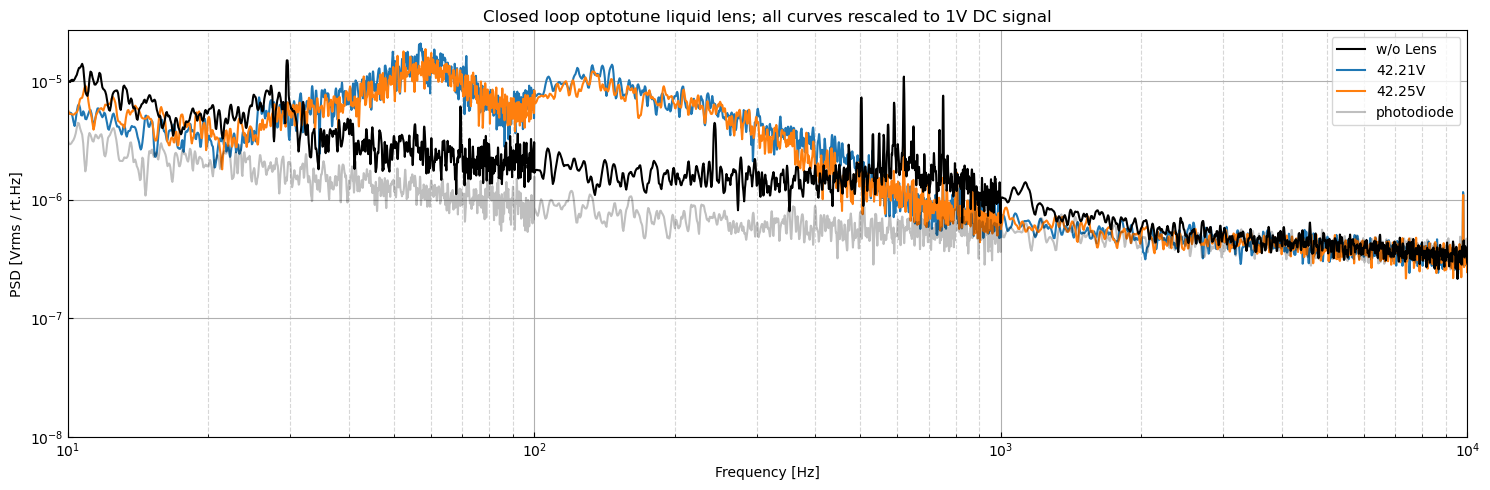

In [ ]:
fig, ax = plt.subplots(figsize=[15, 5])

k = 'direct_20dB'
ax.loglog(all_data[k][:,0], all_data[k][:,1], 'k-', label='w/o Lens', alpha=1, zorder=10)

tail_value = all_data[k][-1000:,1].mean()
labels = ['42.21V', '42.25V']
for i, k in enumerate(['varioptic_42.21V_20dB', 'varioptic_42.25V_20dB']):
    mult = tail_value / all_data[k][-1000:,1].mean()
    mult = 1
    ax.loglog(all_data[k][:,0], all_data[k][:,1] * mult, label=labels[i], zorder=2)

k = 'pd_20dB'
ax.loglog(all_data[k][:,0], all_data[k][:,1], 'k-', label='photodiode', alpha=0.25)

# for i, v in enumerate([60, 120, 240, 360, 480, 600]):
#     ax.axvline(v, color='r', linestyle='--', alpha=0.5, ymax=0.25, label="AC" if i==0 else "")

plt.legend()
plt.grid()
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.grid(which='minor', linestyle='--', alpha=0.5)
plt.xlim([1e1, 1e4])
plt.ylim([1e-8, None])
ax.tick_params(direction='in')
ax.tick_params(which='minor', direction='in')
plt.title(f"Closed loop optotune liquid lens; all curves rescaled to 1V DC signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Vrms / rt.Hz]")

plt.tight_layout()

## Varioptic Open Loop 2; with Ch1 Range 0dBm

dict_keys(['varioptic_42.30V_20dB', 'pd_20dB', 'varioptic_41.90V_20dB', 'w/oLens_20dB'])


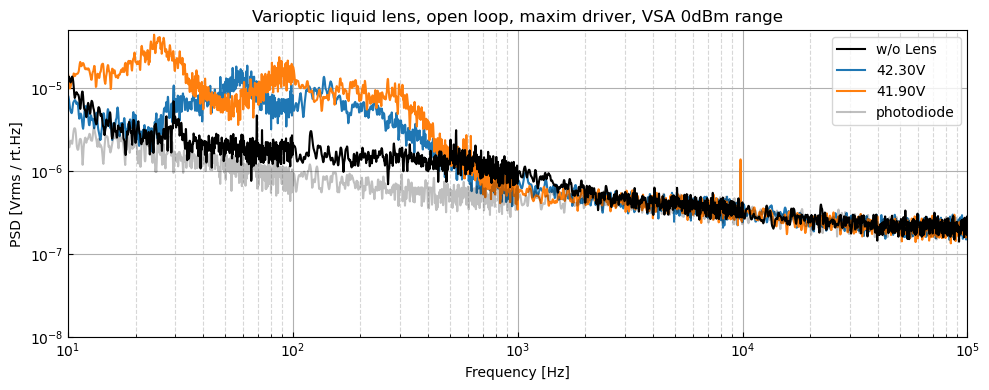

In [ ]:
with open("open_loop_varioptic_liquid_lens_20230519_ch1range0dB.pkl", "rb") as f:
    all_data = pickle.load(f)
print(all_data.keys())

fig, ax = plt.subplots(figsize=[10, 4])

k = 'w/oLens_20dB'
ax.loglog(all_data[k][:,0], all_data[k][:,1], 'k-', label='w/o Lens', alpha=1, zorder=10)

tail_value = all_data[k][-1000:,1].mean()
labels = ['42.30V', '41.90V']
for i, k in enumerate(['varioptic_42.30V_20dB', 'varioptic_41.90V_20dB']):
    mult = tail_value / all_data[k][-1000:,1].mean()
    mult = 1
    ax.loglog(all_data[k][:,0], all_data[k][:,1] * mult, label=labels[i], zorder=2)

k = 'pd_20dB'
ax.loglog(all_data[k][:,0], all_data[k][:,1], 'k-', label='photodiode', alpha=0.25)

# for i, v in enumerate([60, 120, 240, 360, 480, 600]):
#     ax.axvline(v, color='r', linestyle='--', alpha=0.5, ymax=0.25, label="AC" if i==0 else "")

plt.legend()
plt.grid()
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.grid(which='minor', linestyle='--', alpha=0.5)
plt.xlim([1e1, 1e5])
plt.ylim([1e-8, 5e-5])
ax.tick_params(direction='in')
ax.tick_params(which='minor', direction='in')
plt.title(f"Varioptic liquid lens, open loop, maxim driver, VSA 0dBm range")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Vrms / rt.Hz]")

plt.tight_layout()

## MMVOA 0dB gain, 0dBm range

In [ ]:
with open("mmvoa_0dB_0dBm.pkl", "rb") as f:
    all_data = pickle.load(f)
print(all_data.keys())

dict_keys(['VOA_CL_7dB_500Hz', 'VOA_CL_4dB_500Hz', 'VOA_CL_-5dB_500Hz', 'VOA_OL', 'PD', 'VSA_50Ohm'])


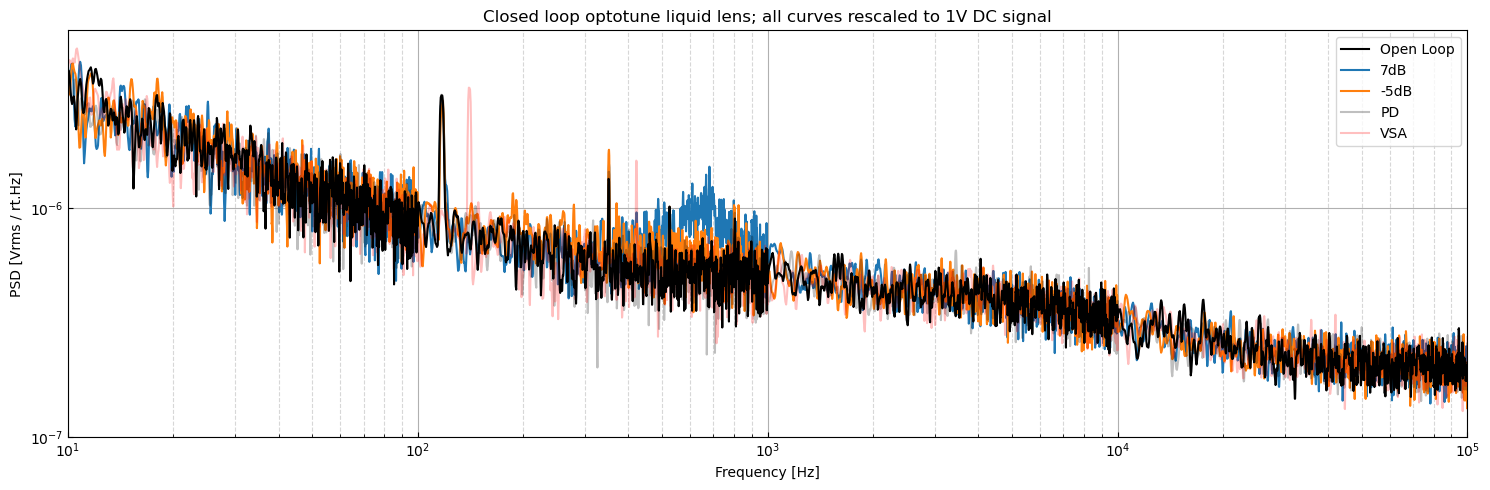

In [ ]:
fig, ax = plt.subplots(figsize=[15, 5])

k = 'VOA_OL'
ax.loglog(all_data[k][:,0], all_data[k][:,1], 'k-', label='Open Loop', alpha=1, zorder=10)

tail_value = all_data[k][-1000:,1].mean()
labels = ['7dB', '-5dB']
for i, k in enumerate(['VOA_CL_7dB_500Hz', 'VOA_CL_-5dB_500Hz']):
    mult = tail_value / all_data[k][-1000:,1].mean()
    mult = 1
    ax.loglog(all_data[k][:,0], all_data[k][:,1] * mult, label=labels[i], zorder=2)

k = 'PD'
ax.loglog(all_data[k][:,0], all_data[k][:,1], 'k-', label='PD', alpha=0.25)

k = 'VSA_50Ohm'
ax.loglog(all_data[k][:,0], all_data[k][:,1], 'r-', label='VSA', alpha=0.25)

# for i, v in enumerate([60, 120, 240, 360, 480, 600]):
#     ax.axvline(v, color='r', linestyle='--', alpha=0.5, ymax=0.25, label="AC" if i==0 else "")

plt.legend()
plt.grid()
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.grid(which='minor', linestyle='--', alpha=0.5)
plt.xlim([1e1, 1e5])
plt.ylim([1e-7, None])
ax.tick_params(direction='in')
ax.tick_params(which='minor', direction='in')
plt.title(f"Closed loop optotune liquid lens; all curves rescaled to 1V DC signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Vrms / rt.Hz]")

plt.tight_layout()

## MMVOA 20dB gain, -30dBm range

In [ ]:
# MMVOA, -30dBm, 20dB 
# OL: 1.25V 
# CL: 250mV st = 0.867V

dict_keys(['VOA_OL', 'PD', 'CL_7dB_500Hz', 'CL_0dB_500Hz', 'CL_10dB_100Hz', 'CL_10dB_250Hz'])


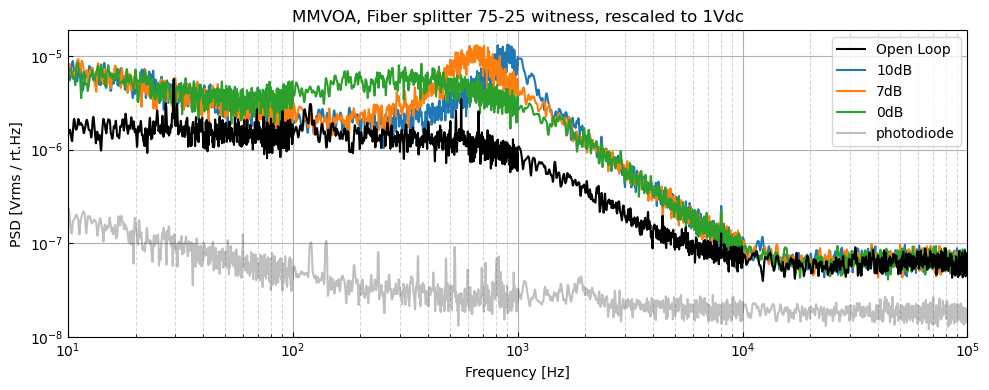

In [ ]:
with open("mmvoa_20dB_-30dBm.pkl", "rb") as f:
    all_data = pickle.load(f)
print(all_data.keys())

fig, ax = plt.subplots(figsize=[10, 4])

k = 'VOA_OL'
ax.loglog(all_data[k][:,0], all_data[k][:,1]/1.25, 'k-', label='Open Loop', alpha=1, zorder=10)

tail_value = all_data[k][-1000:,1].mean()
labels = ['10dB', '7dB', '0dB']
for i, k in enumerate(['CL_10dB_250Hz', 'CL_7dB_500Hz', 'CL_0dB_500Hz']):
    mult = tail_value / all_data[k][-1000:,1].mean()
    mult = 1
    ax.loglog(all_data[k][:,0], all_data[k][:,1]/0.867, label=labels[i], zorder=2)

k = 'PD'
ax.loglog(all_data[k][:,0], all_data[k][:,1], 'k-', label='photodiode', alpha=0.25)

# for i, v in enumerate([60, 120, 240, 360, 480, 600]):
#     ax.axvline(v, color='r', linestyle='--', alpha=0.5, ymax=0.25, label="AC" if i==0 else "")

plt.legend()
plt.grid()
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.grid(which='minor', linestyle='--', alpha=0.5)
plt.xlim([1e1, 1e5])
plt.ylim([1e-8, None])
ax.tick_params(direction='in')
ax.tick_params(which='minor', direction='in')
plt.title(f"MMVOA, Fiber splitter 75-25 witness, rescaled to 1Vdc")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Vrms / rt.Hz]")

plt.tight_layout()

## MMVOA 20dB gain, -30dBm range, T off measure signal

In [ ]:
# MMVOA: direct 
# CL 250mV = 190.5mV 
# OL 243.8mV 

dict_keys(['Instrument', 'OL', 'CL_10dB_250Hz'])


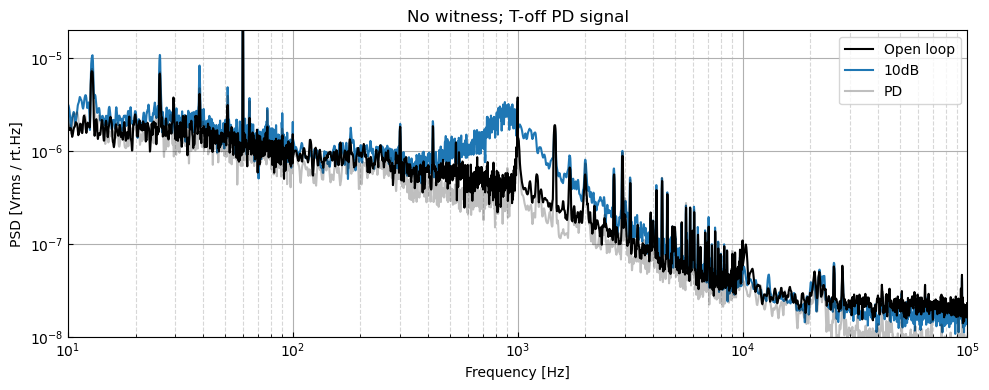

In [ ]:
with open("mmvoa_20dB_-30dBm_direct.pkl", "rb") as f:
    all_data = pickle.load(f)
print(all_data.keys())

fig, ax = plt.subplots(figsize=[10, 4])

k = 'OL'
ax.loglog(all_data[k][:,0], all_data[k][:,1], 'k-', label='Open loop', alpha=1, zorder=10)

tail_value = all_data[k][-1000:,1].mean()
labels = ['10dB']
for i, k in enumerate(['CL_10dB_250Hz']):
    mult = tail_value / all_data[k][-1000:,1].mean()
    mult = 1
    ax.loglog(all_data[k][:,0], all_data[k][:,1], label=labels[i], zorder=2)

k = 'Instrument'
ax.loglog(all_data[k][:,0], all_data[k][:,1], 'k-', label='PD', alpha=0.25)


# for i, v in enumerate([60, 120, 240, 360, 480, 600]):
#     ax.axvline(v, color='r', linestyle='--', alpha=0.5, ymax=0.25, label="AC" if i==0 else "")

plt.legend()
plt.grid()
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.grid(which='minor', linestyle='--', alpha=0.5)
plt.xlim([1e1, 1e5])
plt.ylim([1e-8, 2e-5])
ax.tick_params(direction='in')
ax.tick_params(which='minor', direction='in')
plt.title(f"No witness; T-off PD signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Vrms / rt.Hz]")

plt.tight_layout()

## MMVOA 20dB gain, -30dBm range, BS

In [ ]:
# OL: 2.95V
# CL: 1.914V
# Inst. 0.023V

In [ ]:
with open("mmvoa_20dB_-30dBm_pbs.pkl", "rb") as f:
    all_data = pickle.load(f)
print(all_data.keys())

dict_keys(['OL', 'CL_10dB_100Hz', 'Inst', 'VSA'])


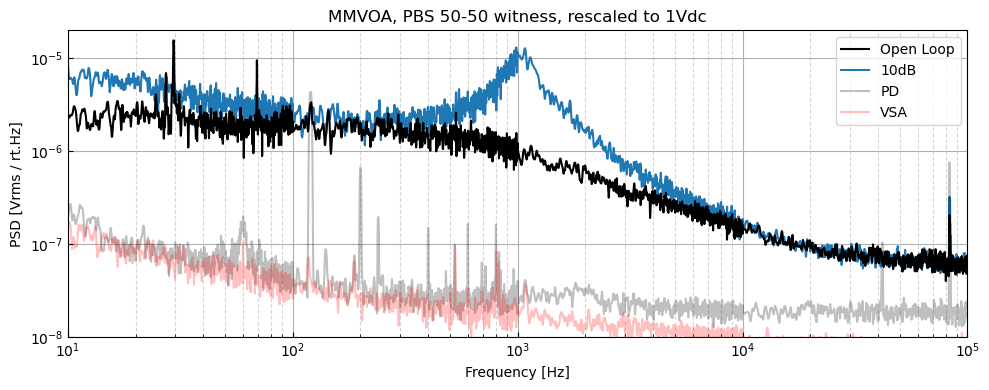

In [ ]:
fig, ax = plt.subplots(figsize=[10, 4])

k = 'OL'
ax.loglog(all_data[k][:,0], all_data[k][:,1]/2.95, 'k-', label='Open Loop', alpha=1, zorder=10)

tail_value = all_data[k][-1000:,1].mean()
labels = ['10dB']
for i, k in enumerate(['CL_10dB_100Hz']):
    # mult = tail_value / all_data[k][-1000:,1].mean()
    # mult = 1
    ax.loglog(all_data[k][:,0], all_data[k][:,1]/1.914, label=labels[i], zorder=2)

k = 'Inst'
ax.loglog(all_data[k][:,0], all_data[k][:,1], 'k-', label='PD', alpha=0.25)

k = 'VSA'
ax.loglog(all_data[k][:,0], all_data[k][:,1], 'r-', label='VSA', alpha=0.25)

# for i, v in enumerate([60, 120, 240, 360, 480, 600]):
#     ax.axvline(v, color='r', linestyle='--', alpha=0.5, ymax=0.25, label="AC" if i==0 else "")

plt.legend()
plt.grid()
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.grid(which='minor', linestyle='--', alpha=0.5)
plt.xlim([1e1, 1e5])
plt.ylim([1e-8, 2e-5])
ax.tick_params(direction='in')
ax.tick_params(which='minor', direction='in')
plt.title(f"MMVOA, PBS 50-50 witness, rescaled to 1Vdc")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Vrms / rt.Hz]")

plt.tight_layout()

In [ ]:
df['t_utc'] = pd.to_datetime(df.t, unit='s', utc=True)
df['t_pst'] = df.t_utc.dt.tz_convert('US/PACIFIC')
df.plot(x='t_pst', y='delta_fit_kHz', ax=ax)